# **Red Wine Quality Prediction** | Multiple-Class Regression

**Assignment 2 | EE4685 Machine Learning, a Bayesian Perspective**

*Authors: Yanqi Hong (5884683)
         Hongrui Liu (6005608)*

## 1. Importing Libraries and Data

In [34]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import random
import pygwalker as pyg
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB,ComplementNB
from collections import Counter
from torch.distributions import constraints
from functools import partial
from sklearn import linear_model


import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.nn import PyroSample
from pyro.nn import PyroModule
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS, Predictive
import tyxe
from functools import partial

import torchbnn as bnn
from torchhk import transform_model

import gaussianize as g

#Neural Network libraries
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.utils.data as data

device = "cuda"

# Set random seed
np.random.seed(888)
random_state = 888
pyro.set_rng_seed(888)
#cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
print("Using CUDA: ", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

Using CUDA:  True


In [35]:
# Load data
#Hong's path: data=pd.read_csv('E:\DATA\TUD\Master\TUD_Master_Y1\Q3\EE4685 Machine Learning, a Bayesian Perspective\Assignment 2\Data\winequality-red.csv')
wine_data=pd.read_csv('E:\DATA\TUD\Master\TUD_Master_Y1\Q3\EE4685 Machine Learning, a Bayesian Perspective\Assignment 2\Data\winequality-red.csv')

display(wine_data)
# walker = pyg.walk(wine_data)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## 2. Data preprocessing

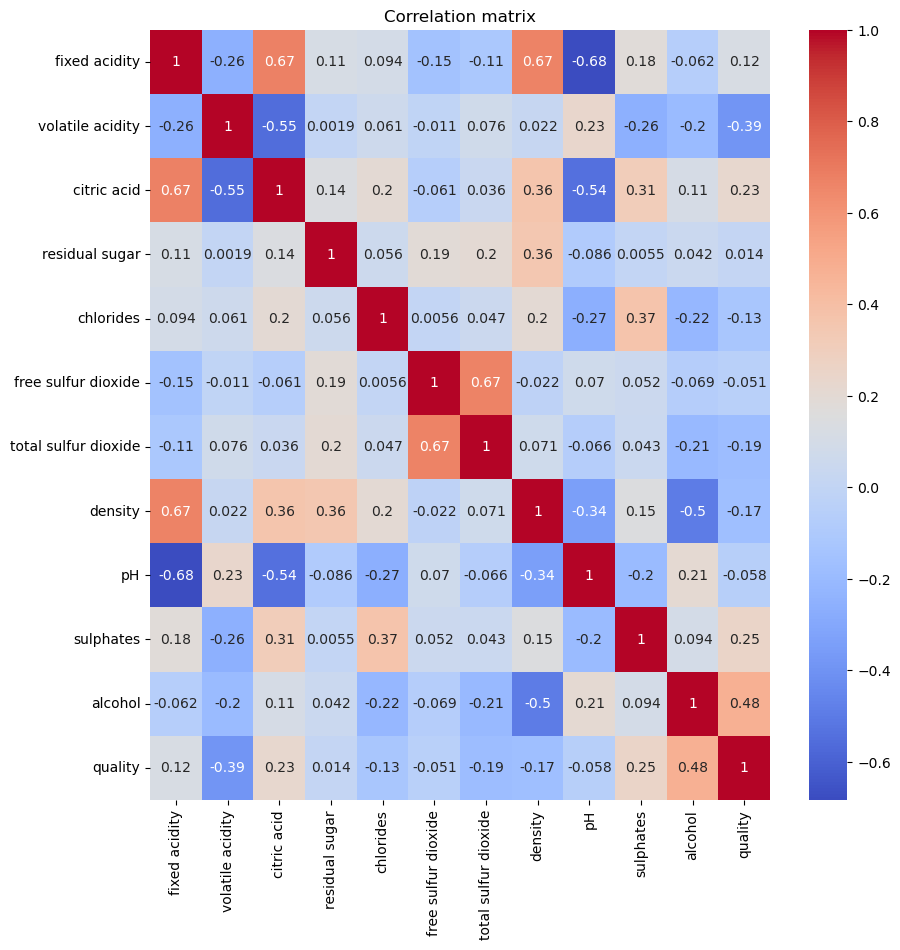

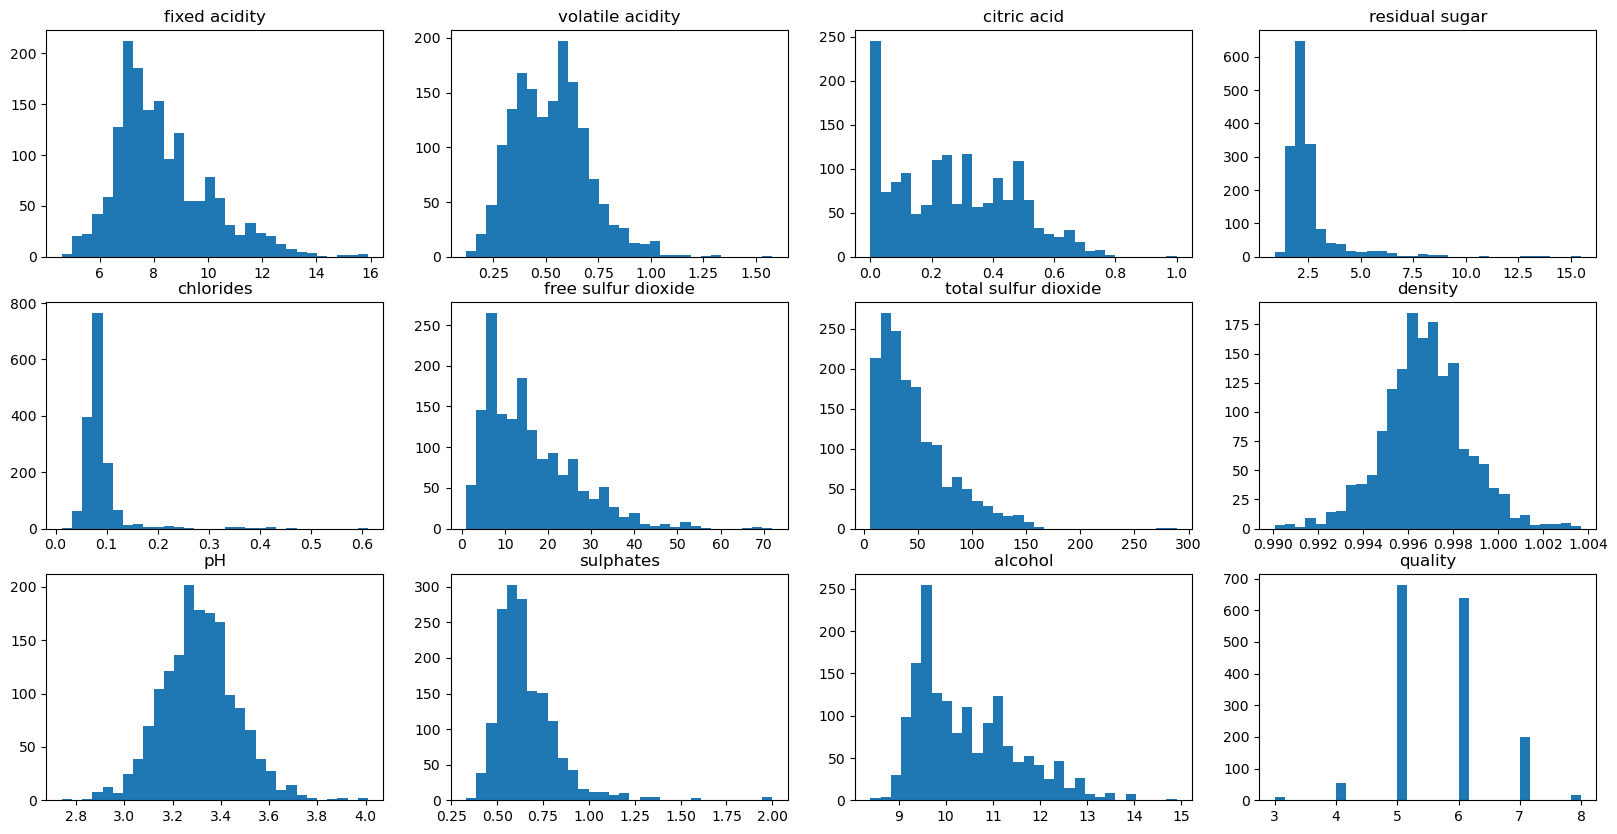

In [36]:
# Visualize data
# Correlation matrix, quality is the target variable
correlation_matrix = wine_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()



#Draw two histogram in one plot(one for good wine and one for bad wine), to see the distribution of each feature
plt.figure(figsize=(20, 10))
for i in range(0, 12):
    plt.subplot(3, 4, i+1)
    plt.hist(wine_data.iloc[:, i], bins=30)
    plt.title(wine_data.columns[i])
plt.show()





In [37]:
# calculate the number of samples in each quality class
quality_classes = wine_data['quality'].value_counts()
print(quality_classes)

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


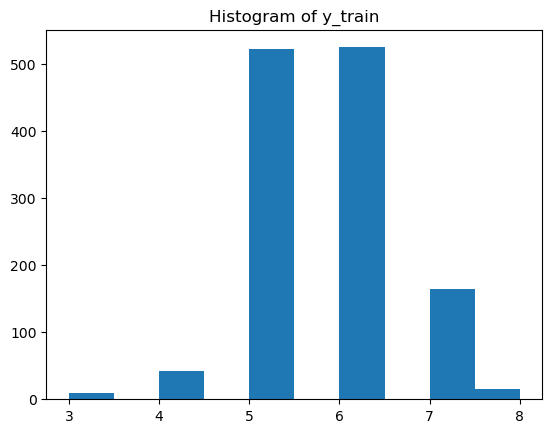

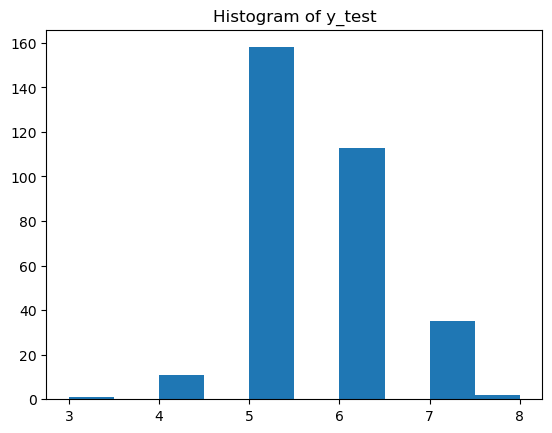

train 6    525
5    523
7    164
4     42
8     16
3      9
dtype: int64
test 5    158
6    113
7     35
4     11
8      2
3      1
dtype: int64


In [38]:
x = wine_data.iloc[:, :-1].values
y = wine_data.iloc[:, -1].values

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=888)

#Histogram of the y_train
plt.hist(y_train, bins=10)
plt.title('Histogram of y_train')
plt.show()

#Histogram of the y_test
plt.hist(y_test, bins=10)
plt.title('Histogram of y_test')
plt.show()

# calculate the number of samples in each quality class
quality_classes_train = pd.Series(y_train).value_counts()
quality_classes_test = pd.Series(y_test).value_counts()
print("train",quality_classes_train)
print("test",quality_classes_test)





In [39]:

# Standardize features
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)



The original number of training feature is:  11


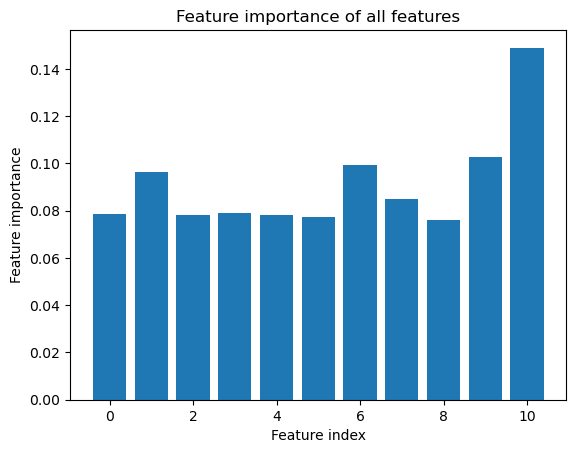

In [40]:

# Feature selection by extra tree classifier

print("The original number of training feature is: ", x_train.shape[1])
clf_etc = ExtraTreesClassifier(random_state=random_state).fit(x_train, y_train) # fit the model
feature_importances = clf_etc.feature_importances_  # get the feature importance

plt.bar(range(len(feature_importances)), feature_importances)   # plot the feature importance
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.title("Feature importance of all features")
plt.show()

# Feature is not too many, so we don't need to do feature selection
# However, if we want to do feature selection, we can use the following code
#---#
# important_feature_indices=np.argsort(feature_importances)   # sort the feature importance  
# important_feature_indices_cut=important_feature_indices[:int(len(important_feature_indices)/1.5)]   # select the most important features  
# X_train_selected=np.delete(x_train_scaled,important_feature_indices_cut,1)    # delete the least important features
# X_test_selected=np.delete(x_test_scaled,important_feature_indices_cut,1)      # delete the least important features
# print("The current number of training feature after feature selection is: ", X_train_selected.shape[1])
#---#





In [41]:

# Feature selection by PCA
pca0 = PCA().fit(x_train)



The number of features that explain 95% variance:  8


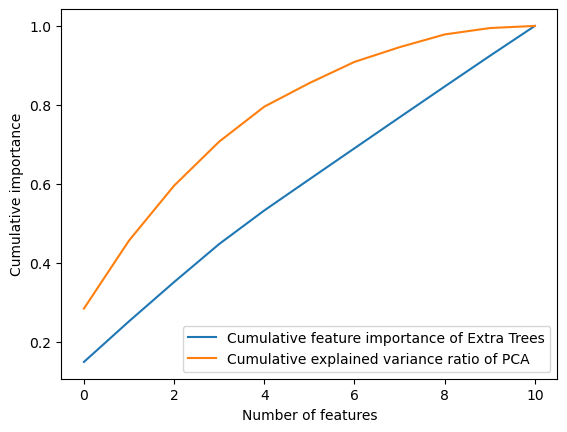

In [42]:

# Plot the cumulative explained variance ratio for PCA and cumulative feature importance for Extra Trees
plt.plot(np.sort(feature_importances)[::-1].cumsum(), label='Cumulative feature importance of Extra Trees')
plt.plot(pca0.explained_variance_ratio_.cumsum(), label='Cumulative explained variance ratio of PCA')
plt.xlabel('Number of features')
plt.ylabel('Cumulative importance')
plt.legend()

print("The number of features that explain 95% variance: ", np.where(pca0.explained_variance_ratio_.cumsum() > 0.95)[0][0])

The number of negative values in x_train is:  8265


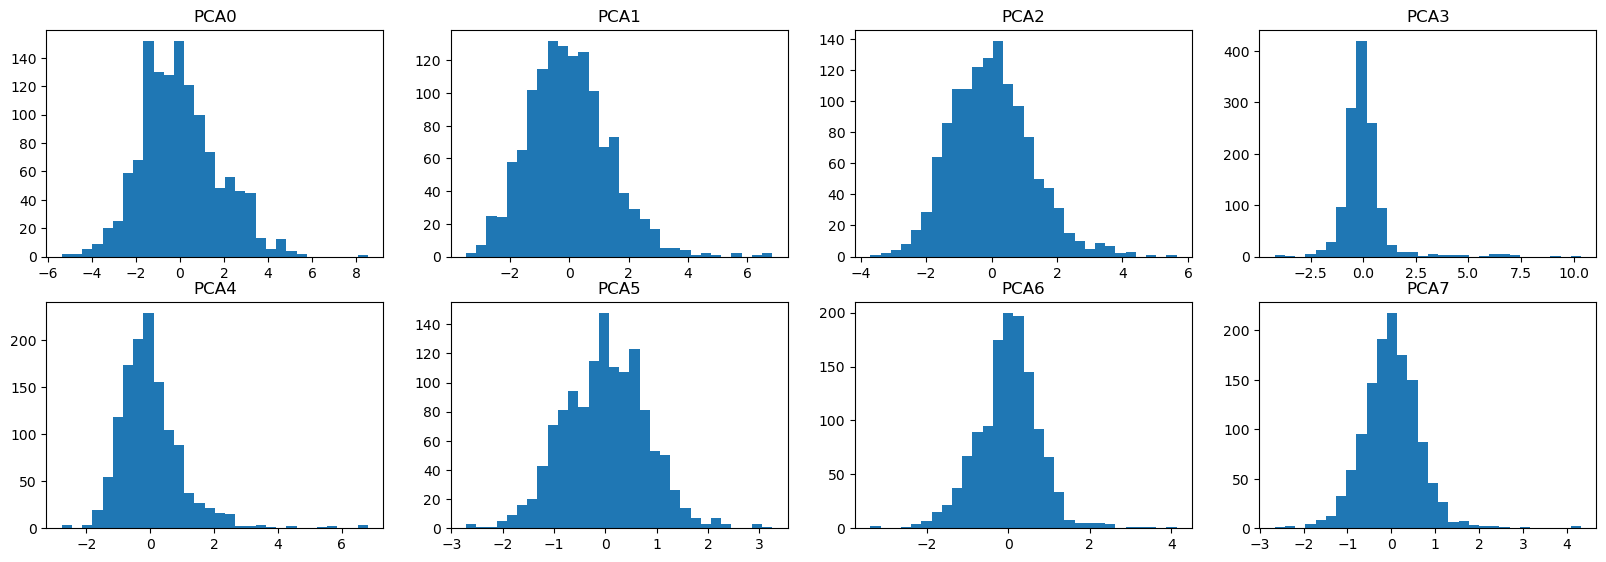

The number of negative values in x_train is:  5365


In [43]:
#check the negative values in the data
print("The number of negative values in x_train is: ", np.sum(x_train<0))

#PCA will generate negative values

# Feature selection by PCA, number of features that explain 95% variance, n_components=8
pca=PCA(n_components=8)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

#histgram of the x_train
plt.figure(figsize=(20, 10))
for i in range(0, 8):
    plt.subplot(3, 4, i+1)
    plt.hist(x_train[:, i], bins=30)
    plt.title("PCA"+str(i))
plt.show()


#check the negative values in the data
print("The number of negative values in x_train is: ", np.sum(x_train<0))

The original sample number of 3 is 9
The original sample number of 4 is 42
The original sample number of 5 is 523
The original sample number of 6 is 525
The original sample number of 7 is 164
The original sample number of 8 is 16


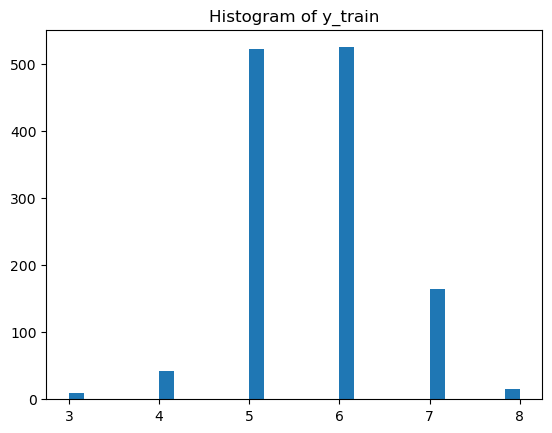

In [44]:
# oversample and undersample

quality_list=[3,4,5,6,7,8]
# quality_list=[0,1]
num_quanlity_list=[]
for i in quality_list:
    num_quanlity_list.append(np.sum(y_train==i))
    print('The original sample number of', i, 'is', num_quanlity_list[-1])

#Histogram of the y_train
plt.hist(y_train, bins=30)
plt.title('Histogram of y_train')
plt.show()

print("")

#Due to overfittings, we don't use oversampling and undersampling
# # oversampling & undersampling
# smt = SMOTETomek(random_state=random_state)
# x_train, y_train = smt.fit_resample(x_train, y_train)
# num_quanlity_list=[]
# for i in quality_list:
#     num_quanlity_list.append(np.sum(y_train==i))
#     print('The processed sample number of', i, 'is', num_quanlity_list[-1])

# #Histogram of the y_train
# plt.hist(y_train, bins=30)
# plt.title('Histogram of y_train')
# plt.show()




## 3. Regression Models

In [45]:
#Evalution function
def performance_eval(true, pred, score_display=True, matrix_display=False, result_return=False,multiple_pred=False,binary=False):
    """
    Evaluate the performance of a prediction model.

    Parameters:
    true (array-like): The true labels.
    pred (array-like): The predicted labels.
    score_display (bool, optional): Whether to display the performance scores. Default is True.
    matrix_display (bool, optional): Whether to display the confusion matrix. Default is False.
    result_return (bool, optional): Whether to return the performance scores. Default is False.
    multiple_pred (bool, optional): Whether there are multiple predictions. Default is False.
    binary (bool, optional): Whether the problem is binary classification. Default is False.

    Returns:
    If result_return is True:
        If binary is True:
            Tuple: (Accuracy, F1 score, Precision, Recall)
        If binary is False:
            float: Accuracy
    If result_return is False:
        None
    """

    if multiple_pred:
        mse_list = []
        F1_list = []
        Precision_list = []
        Recall_list = []
        
        Accuracy = 0
        F1 = 0
        Precision = 0
        Recall = 0
        
        for i in range(len(pred)):
            mse_list.append(accuracy_score(true, pred[i]))
            if binary:
                F1_list.append(f1_score(true, pred[i]))
                Precision_list.append(precision_score(true, pred[i]))
                Recall_list.append(recall_score(true, pred[i]))
        
        Accuracy = np.mean(mse_list)
        F1 = np.mean(F1_list)
        Precision = np.mean(Precision_list)
        Recall = np.mean(Recall_list)
        
        if score_display==True:
            print("Accuracy: " + str(Accuracy))
            if binary:
                print("F1 score: " + str(F1))
                print("Recall score: " + str(Recall))
                print("Precision score: " + str(Precision))
            
        if matrix_display==True:
            label = [3,4,5,6,7,8]
            # label = ["bad","good"]
            cm_list = []
            for i in range(len(pred)):
                cm_list.append(confusion_matrix(true, pred[i])) 
            cm = np.mean(cm_list, axis=0)   # average the confusion matrix
            # cm is integer
            cm = cm.astype(int)
            cm_display = ConfusionMatrixDisplay(cm, display_labels=label).plot()
            plt.show(cm_display)
    else:
        Accuracy = accuracy_score(true, pred)
        if binary:
            F1 = f1_score(true, pred)
            Precision = precision_score(true, pred)
            Recall = recall_score(true, pred)
        
        if score_display==True:
            print("Accuracy: " + str(Accuracy))
            if binary:
                print("F1 score: " + str(F1))
                print("Recall score: " + str(Recall))
                print("Precision score: " + str(Precision))
            
        if matrix_display==True:
            label = [3,4,5,6,7,8]
            # label = ["bad","good"]
            cm = confusion_matrix(true, pred)
            cm_display = ConfusionMatrixDisplay(cm, display_labels=label).plot()
            plt.show(cm_display)
    
    if result_return:
        if binary:
            return Accuracy, F1, Precision, Recall
        else:
            return Accuracy
        

def mse_eval(true, pred, score_display=True, result_return=False, plot_display=False):
    """
    Calculate the mean squared error (MSE) between true and predicted values.

    Parameters:
    true (array-like): The true values.
    pred (array-like): The predicted values.
    score_display (bool, optional): Whether to display the MSE score. Default is True.
    result_return (bool, optional): Whether to return the MSE score. Default is False.
    plot_display (bool, optional): Whether to display a scatter plot of true and predicted values. Default is False.

    Returns:
    float or None: The MSE score if result_return is True, otherwise None.
    """

    mse = mean_squared_error(true, pred)

    if score_display:
        print("MSE: " + str(mse))
    
    if plot_display:
        plt.figure(figsize=(15, 5))
        plt.scatter(np.arange(len(true)), true, marker="x", label='True value',c='purple')
        plt.scatter(np.arange(len(pred)), pred, marker=".", label='Predicted value',c='r')
        plt.fill_between(np.arange(len(true)), true+mse, true-mse, color='pink', alpha=0.4, label='MSE')
        plt.legend()
        plt.grid()
        plt.show()

    if result_return:
        return mse

###  3.1 Bayes Ridge Regression

In [46]:
#bayes regression
##random search

num_iter_search=500

br=linear_model.BayesianRidge() 

param_dist ={"alpha_1": np.logspace(-6, 1, num=100),"alpha_2": np.logspace(-6, 1, num=100),
             "lambda_1": np.logspace(-6, 1, num=100),"lambda_2": np.logspace(-6, 1, num=100),
              }

random_search = RandomizedSearchCV(br, param_distributions=param_dist, n_iter=num_iter_search, cv=5, random_state=random_state, n_jobs=8,scoring='neg_mean_squared_error')

random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_



MSE: 0.3993372320169581


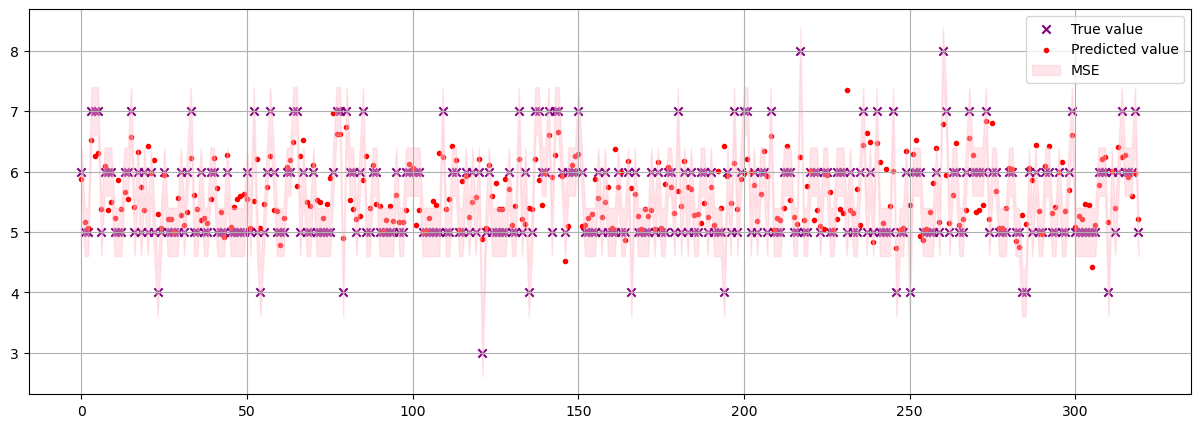

Accuracy: 0.61875


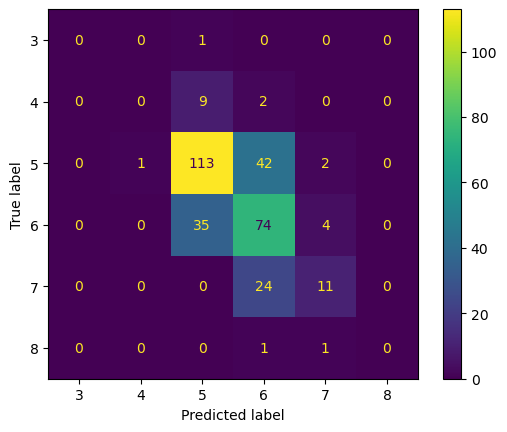

In [47]:

# Generate the performance value and confusion matrix on test set
y_pred = random_search.predict(x_test)
mse=mse_eval(y_test, y_pred, score_display=True, result_return=True, plot_display=True)

# round the y_pred to the nearest integer, so the regression result can be compared with the classification result
y_pred = np.round(y_pred)
y_pred = np.clip(y_pred, 0, 10)
y_pred = y_pred.astype(int)
Accuracy=performance_eval(y_test, y_pred, matrix_display=True, result_return=True)

In [48]:

#bayesian ridge summary
print("-----------------Bayesian Ridge Summary-----------------")
print("Best parameters:", best_params)
print("Best mse in cross validation process:", -best_score)
print("Accuracy in test set with best parameters: " + str(Accuracy))
print("MSE in test set with best parameters: " + str(mse))
print("-------------------------------------------------------------")

-----------------Bayesian Ridge Summary-----------------
Best parameters: {'lambda_2': 0.07564633275546291, 'lambda_1': 7.220809018385457, 'alpha_2': 0.006579332246575676, 'alpha_1': 1.3530477745798076e-05}
Best mse in cross validation process: 0.43980867771786497
Accuracy in test set with best parameters: 0.61875
MSE in test set with best parameters: 0.3993372320169581
-------------------------------------------------------------


### 3.2 ARD regression

In [49]:
#ARD

num_iter_search=500

ard=linear_model.ARDRegression()

param_dist ={"alpha_1": np.logspace(-6, 1, num=100),"alpha_2": np.logspace(-6, 1, num=100),
                "lambda_1": np.logspace(-6, 1, num=100),"lambda_2": np.logspace(-6, 1, num=100),
                }

random_search = RandomizedSearchCV(ard, param_distributions=param_dist, n_iter=num_iter_search, cv=5, random_state=random_state, n_jobs=8,scoring='neg_mean_squared_error')

random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_


MSE: 0.39911834466555185


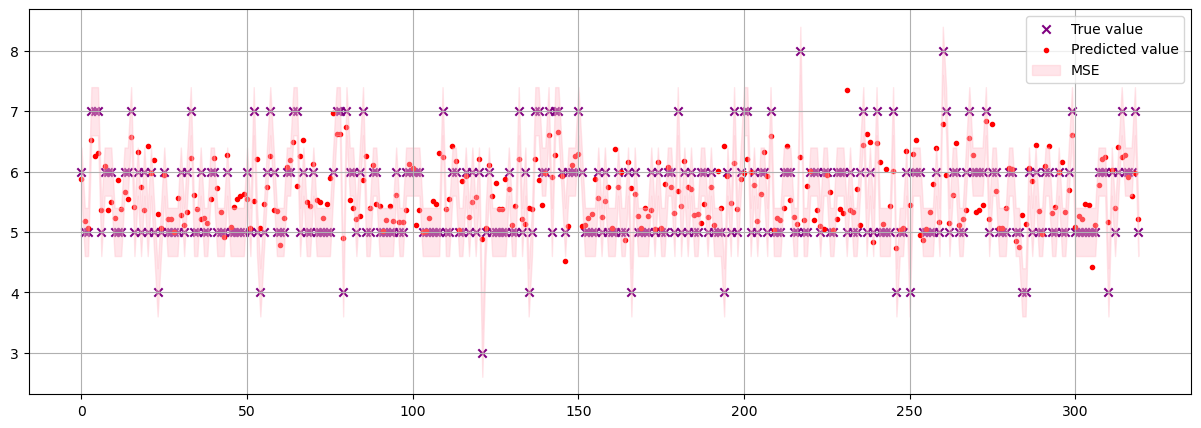

Accuracy: 0.61875


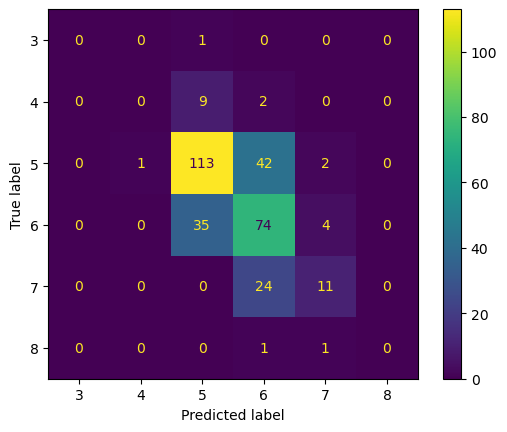

In [50]:
# Generate the performance value and confusion matrix on test set
y_pred = random_search.predict(x_test)
mse=mse_eval(y_test, y_pred, score_display=True, result_return=True, plot_display=True)

# round the y_pred to the nearest integer, so the regression result can be compared with the classification result
y_pred = np.round(y_pred)
y_pred = np.clip(y_pred, 0, 10)
y_pred = y_pred.astype(int)
Accuracy=performance_eval(y_test, y_pred, matrix_display=True, result_return=True)



In [51]:
#ARD summary
print("-----------------ARD Summary-----------------")
print("Best parameters:", best_params)
print("Best mse in cross validation process:", -best_score)
print("Accuracy in test set with best parameters: " + str(Accuracy))
print("MSE in test set with best parameters: " + str(mse))
print("-------------------------------------------------------------")

-----------------ARD Summary-----------------
Best parameters: {'lambda_2': 0.07564633275546291, 'lambda_1': 7.220809018385457, 'alpha_2': 0.006579332246575676, 'alpha_1': 1.3530477745798076e-05}
Best mse in cross validation process: 0.43979225679703626
Accuracy in test set with best parameters: 0.61875
MSE in test set with best parameters: 0.39911834466555185
-------------------------------------------------------------


### 3.3 Linear regression



In [52]:
#linera regression

#random search

num_iter_search=500

lr=LinearRegression()

param_dist ={"fit_intercept": [True, False]}
random_search = RandomizedSearchCV(lr, param_distributions=param_dist, n_iter=num_iter_search, cv=5, random_state=random_state, n_jobs=8,scoring='neg_mean_squared_error')

random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_



C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MSE: 0.4006995761161397


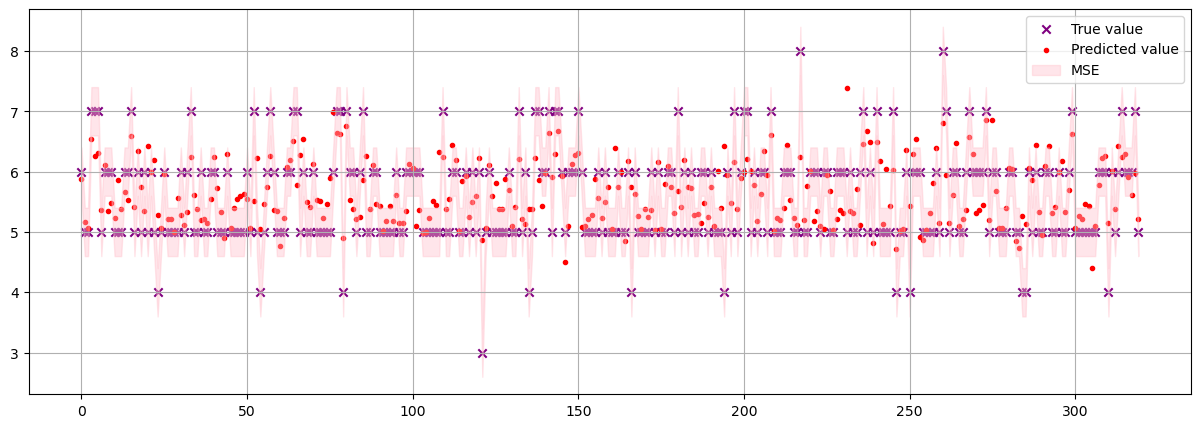

Accuracy: 0.61875


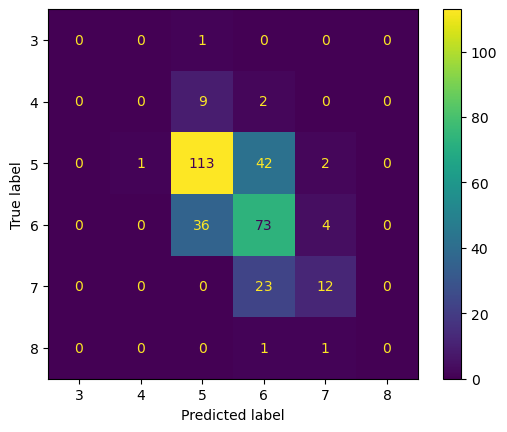

In [53]:

# Generate the performance value and confusion matrix on test set
y_pred = random_search.predict(x_test)
mse=mse_eval(y_test, y_pred, score_display=True, result_return=True, plot_display=True)

# round the y_pred to the nearest integer, so the regression result can be compared with the classification result
y_pred = np.round(y_pred)
y_pred = np.clip(y_pred, 0, 10)
y_pred = y_pred.astype(int)
Accuracy=performance_eval(y_test, y_pred, matrix_display=True, result_return=True)



In [54]:
#Linear Regression summary
print("-----------------Linear Regression Summary-----------------")
print("Best parameters:", best_params)
print("Best mse in cross validation process:", -best_score)
print("Accuracy in test set with best parameters: " + str(Accuracy))
print("MSE in test set with best parameters: " + str(mse))
print("-------------------------------------------------------------")


-----------------Linear Regression Summary-----------------
Best parameters: {'fit_intercept': True}
Best mse in cross validation process: 0.4399148858217877
Accuracy in test set with best parameters: 0.61875
MSE in test set with best parameters: 0.4006995761161397
-------------------------------------------------------------


### 3.4 Lasso regression

In [55]:
#random search
num_iter_search=500

lasso=linear_model.Lasso()

param_dist ={"alpha": np.logspace(-6, 1, num=100)}

random_search = RandomizedSearchCV(lasso, param_distributions=param_dist, n_iter=num_iter_search, cv=5, random_state=random_state, n_jobs=8,scoring='neg_mean_squared_error')

random_search.fit(x_train, y_train)

best_params = random_search.best_params_

best_score = random_search.best_score_

C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 100 is smaller than n_iter=500. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MSE: 0.40069907594882437


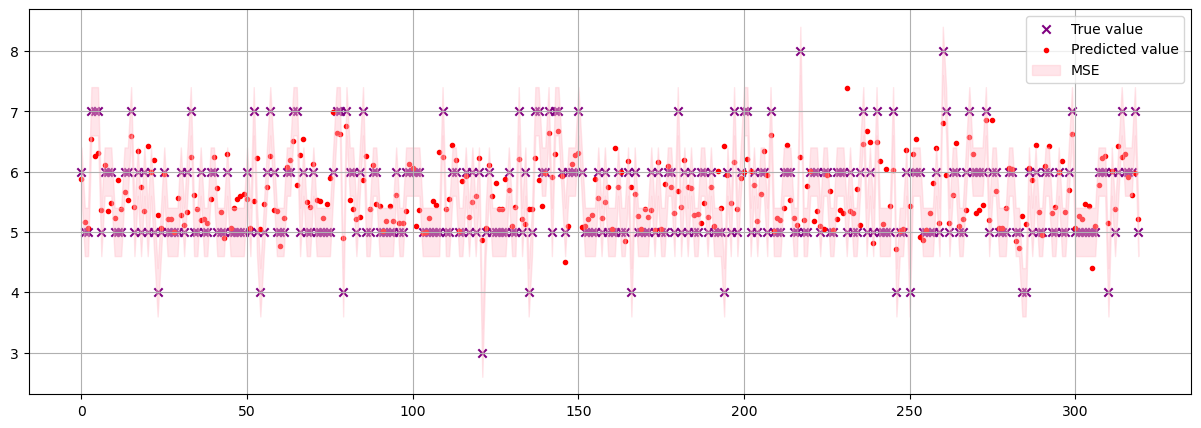

Accuracy: 0.61875


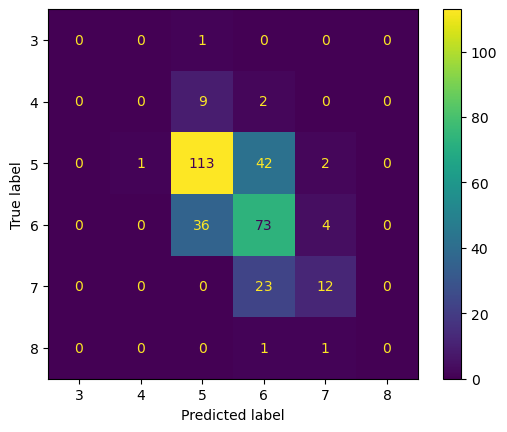

In [56]:
#
# Generate the performance value and confusion matrix on test set
y_pred = random_search.predict(x_test)
mse=mse_eval(y_test, y_pred, score_display=True, result_return=True, plot_display=True)

# round the y_pred to the nearest integer, so the regression result can be compared with the classification result
y_pred = np.round(y_pred)
y_pred = np.clip(y_pred, 0, 10)
y_pred = y_pred.astype(int)
Accuracy=performance_eval(y_test, y_pred, matrix_display=True, result_return=True)


In [57]:
#Lasso summary
print("-----------------Lasso Summary-----------------")
print("Best parameters:", best_params)
print("Best mse in cross validation process:", -best_score)
print("Accuracy in test set with best parameters: " + str(Accuracy))
print("MSE in test set with best parameters: " + str(mse))
print("-------------------------------------------------------------")


-----------------Lasso Summary-----------------
Best parameters: {'alpha': 1e-06}
Best mse in cross validation process: 0.43991490747237527
Accuracy in test set with best parameters: 0.61875
MSE in test set with best parameters: 0.40069907594882437
-------------------------------------------------------------


### 3.5 Ridge regression

In [58]:
#ridge regression
#random search
num_iter_search=500

ridge=linear_model.Ridge()

param_dist ={"alpha": np.logspace(-6, 5, num=100)}

random_search = RandomizedSearchCV(ridge, param_distributions=param_dist, n_iter=num_iter_search, cv=5, random_state=random_state, n_jobs=8,scoring='neg_mean_squared_error')

random_search.fit(x_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 100 is smaller than n_iter=500. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MSE: 0.39918558138641264


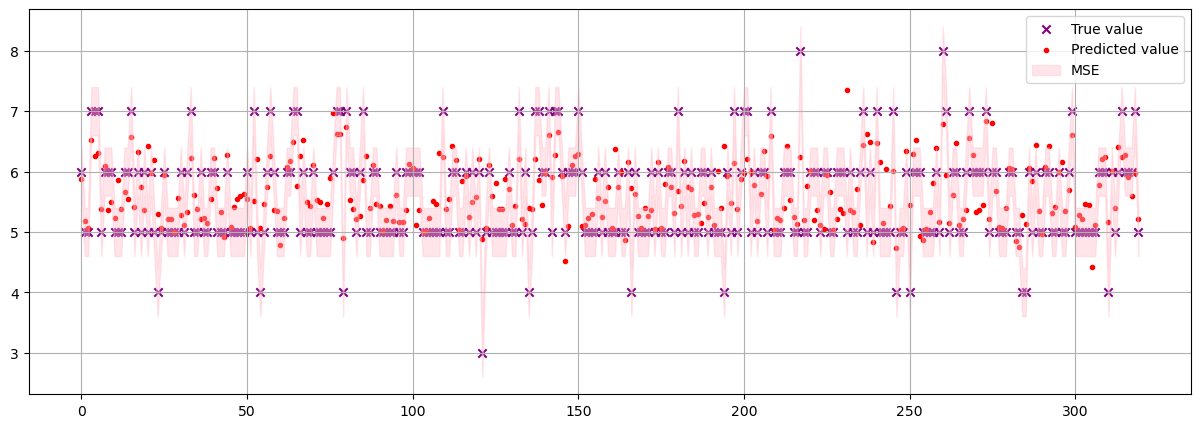

Accuracy: 0.61875


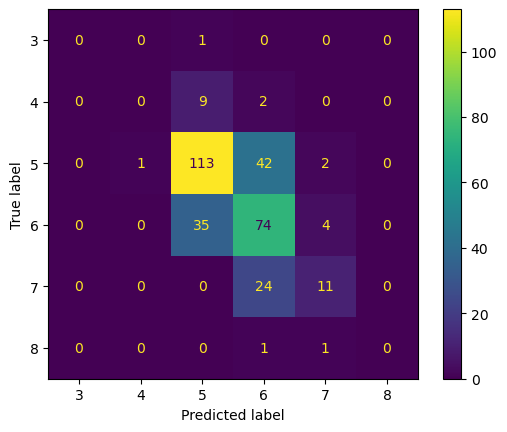

In [59]:
# Generate the performance value and confusion matrix on test set
y_pred = random_search.predict(x_test)
mse=mse_eval(y_test, y_pred, score_display=True, result_return=True, plot_display=True)

# round the y_pred to the nearest integer, so the regression result can be compared with the classification result
y_pred = np.round(y_pred)
y_pred = np.clip(y_pred, 0, 10)
y_pred = y_pred.astype(int)
Accuracy=performance_eval(y_test, y_pred, matrix_display=True, result_return=True)



In [60]:
#Ridge summary
print("-----------------Ridge Summary-----------------")
print("Best parameters:", best_params)
print("Best mse in cross validation process:", -best_score)
print("Accuracy in test set with best parameters: " + str(Accuracy))
print("MSE in test set with best parameters: " + str(mse))
print("-------------------------------------------------------------")

-----------------Ridge Summary-----------------
Best parameters: {'alpha': 35.93813663804626}
Best mse in cross validation process: 0.4397785661883655
Accuracy in test set with best parameters: 0.61875
MSE in test set with best parameters: 0.39918558138641264
-------------------------------------------------------------


### 3.6 Bayesian regression

In [61]:
# Tensor Dataset and DataLoader
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)

#change y from 1279 to 1279*1
y_train = y_train.reshape(-1, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = data.DataLoader(train_dataset, batch_size=len(x), pin_memory_device="cuda", pin_memory=use_cuda)
test_data = data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader = data.DataLoader(test_data, batch_size=len(x_test), pin_memory_device="cuda", pin_memory=use_cuda)


def train_val_split(x, y, val_size=0.2):
    
    # shaffle the data
    random.seed(random_state)
    np.random.seed(random_state)
    x = np.array(x)
    y = np.array(y)
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]
    

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=val_size, random_state=random_state)

    # Tensor Dataset and DataLoader
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)

    #change y from 1279 to 1279*1
    y_train = y_train.reshape(-1, 1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = data.DataLoader(train_dataset, batch_size=len(x), pin_memory_device="cuda", pin_memory=use_cuda)

    val_data = data.TensorDataset(x_val_tensor, y_val_tensor)
    val_loader = data.DataLoader(val_data, batch_size=len(x_test), pin_memory_device="cuda", pin_memory=use_cuda)
    


    return train_loader, val_loader 

In [65]:
# prior search

mu_prior_min=-1
mu_prior_max=1
sigma_prior_min=0
sigma_prior_max=2

hl_size_min=32
hl_size_max=512


def rand_parm(n_iter):

    # make list of n_iter random parameters
    mu_prior_list = []
    sigma_prior_list = []
    hl_size_list = []

    for i in range(n_iter):
        mu_prior = np.random.uniform(mu_prior_min, mu_prior_max)
        sigma_prior = np.random.uniform(sigma_prior_min, sigma_prior_max)
        hl_size = np.random.randint(hl_size_min, hl_size_max)

        mu_prior_list.append(mu_prior)
        sigma_prior_list.append(sigma_prior)
        hl_size_list.append(hl_size)
    return mu_prior_list, sigma_prior_list, hl_size_list

In [66]:

# BNN Regression Model training with MCMC · prior search
# Not using K-fold cross validation, because the data is not large enough and the algorithm is time-consuming

search_iter=100  # search iteration
mse_list=[]
Accuracy_list=[]
mu_prior_list=[]
sigma_prior_list=[]
pm_list=[]
hl_size_list=[]

for iter in range(search_iter):
    print('-----------------Prior Search Iteration: ', iter, '-----------------')
    mu, sigma,hl = rand_parm(search_iter)
    print('mu_piror:', mu[iter])
    print('sigma_prior:', sigma[iter])
    print('hl_size:', hl[iter])

    mu_piror=mu[iter]
    sigma_prior=sigma[iter]
    hl_size=hl[iter]

    

    Acc_temp=[]
    mse_temp=[] 
    bnn_temp=[]

    for i in range(5):

        print('###Cross Validation Iteration: ', i, '###')
        input_size = x_test.shape[-1]
        pyro.clear_param_store()
        net = nn.Sequential(nn.Linear(input_size, hl_size), nn.Softmax(), nn.Linear(hl_size, 1)).to(device) # set the net

        prior = tyxe.priors.IIDPrior(dist.Normal(mu_piror*torch.ones(1, device=device), sigma_prior*torch.ones(1, device=device)))

        kernel = partial(pyro.infer.mcmc.HMC, step_size=1e-3, num_steps=50, target_accept_prob=0.7) # set the kernel with Markov Chain Monte Carlo
        train_loader, val_loader = train_val_split(x_train, y_train, val_size=0.2)
        x_train_len = len(train_loader.dataset.tensors[0])

        obs_model = tyxe.likelihoods.HomoskedasticGaussian(x_train_len, scale=0.1) #create the likelihood model
        bnn = tyxe.bnn.MCMC_BNN(net, prior, obs_model, kernel).to(device)   # set the BNN model
        bnn.fit(train_loader, 900, warmup_steps=300,device=device)  # fit the model, 900 iterations, 300 warmup steps


        print("Predict on the val set")
        # Test on val set
        x_val_tensor = val_loader.dataset.tensors[0].to(device)
        y_val_tensor = val_loader.dataset.tensors[1].to(device)
        y_val=y_val_tensor.cpu().detach().numpy()
        m, sd = bnn.predict(x_val_tensor.to(device), num_predictions=32)   #m is the mean of the prediction, sd is the standard deviation of the prediction

        y_pred = m.cpu().detach().numpy()

        mse=mse_eval(y_val, y_pred, score_display=True, result_return=True, plot_display=False)
        mse_temp.append(mse)


        # round the y_pred to the nearest integer, so the regression result can be compared with the classification result
        y_pred = np.round(y_pred)
        y_pred = np.clip(y_pred, 3, 8)
        y_pred= y_pred.astype(int)
        Accuracy=performance_eval(y_val, y_pred, matrix_display=False, result_return=True)
        Acc_temp.append(Accuracy)

        mu_prior_list.append(mu_piror)
        sigma_prior_list.append(sigma_prior)
        hl_size_list.append(hl_size)


        bnn_temp.append(bnn)

        #find lowest mse
        min_mse = min(mse_temp)
        min_mse_index = mse_temp.index(min_mse)
        bnn_optimal=bnn_temp[min_mse_index]
        

    pm_list.append(bnn_optimal)
    Accuracy_list.append(np.mean(Acc_temp))
    mse_list.append(np.mean(mse_temp))

-----------------Prior Search Iteration:  0 -----------------
mu_piror: -0.03590195953908948
sigma_prior: 0.39027998062146274
hl_size: 400
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:23, 51.22it/s, step size=3.10e-01, acc. prob=0.867] 


Predict on the val set
MSE: 0.52285534
Accuracy: 0.6328125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 62.71it/s, step size=2.86e-01, acc. prob=0.904] 


Predict on the val set
MSE: 0.46145695
Accuracy: 0.64453125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.59it/s, step size=3.34e-01, acc. prob=0.870] 


Predict on the val set
MSE: 0.4667344
Accuracy: 0.6015625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.98it/s, step size=3.32e-01, acc. prob=0.853] 


Predict on the val set
MSE: 0.44437796
Accuracy: 0.62890625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 57.73it/s, step size=3.14e-01, acc. prob=0.812] 


Predict on the val set
MSE: 0.55819196
Accuracy: 0.59375
-----------------Prior Search Iteration:  1 -----------------
mu_piror: -0.7984248422937852
sigma_prior: 0.182431734157106
hl_size: 146
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.12it/s, step size=3.22e-01, acc. prob=0.886] 


Predict on the val set
MSE: 0.40464842
Accuracy: 0.58203125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.51it/s, step size=2.52e-01, acc. prob=0.891] 


Predict on the val set
MSE: 0.50033844
Accuracy: 0.57421875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.17it/s, step size=2.58e-01, acc. prob=0.880] 


Predict on the val set
MSE: 0.48985448
Accuracy: 0.5703125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 77.70it/s, step size=3.04e-01, acc. prob=0.861] 


Predict on the val set
MSE: 0.43186885
Accuracy: 0.57421875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.45it/s, step size=3.55e-01, acc. prob=0.757] 


Predict on the val set
MSE: 0.4623917
Accuracy: 0.5703125
-----------------Prior Search Iteration:  2 -----------------
mu_piror: 0.9608566538568113
sigma_prior: 0.9605299710419122
hl_size: 86
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.15it/s, step size=3.38e-01, acc. prob=0.845] 


Predict on the val set
MSE: 0.50403047
Accuracy: 0.59765625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.40it/s, step size=3.18e-01, acc. prob=0.876] 


Predict on the val set
MSE: 0.45671088
Accuracy: 0.56640625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 64.21it/s, step size=3.53e-01, acc. prob=0.848] 


Predict on the val set
MSE: 0.47989678
Accuracy: 0.578125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.06it/s, step size=3.40e-01, acc. prob=0.824] 


Predict on the val set
MSE: 0.45298308
Accuracy: 0.58203125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 66.00it/s, step size=3.21e-01, acc. prob=0.866] 


Predict on the val set
MSE: 0.46890676
Accuracy: 0.55859375
-----------------Prior Search Iteration:  3 -----------------
mu_piror: -0.08025890194486585
sigma_prior: 0.055488555267094064
hl_size: 91
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 61.70it/s, step size=3.14e-01, acc. prob=0.885] 


Predict on the val set
MSE: 0.42052743
Accuracy: 0.57421875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 62.26it/s, step size=2.97e-01, acc. prob=0.887] 


Predict on the val set
MSE: 0.42471468
Accuracy: 0.55859375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.89it/s, step size=3.37e-01, acc. prob=0.890] 


Predict on the val set
MSE: 0.42535564
Accuracy: 0.546875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.75it/s, step size=3.77e-01, acc. prob=0.805] 


Predict on the val set
MSE: 0.42437357
Accuracy: 0.5625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.53it/s, step size=3.55e-01, acc. prob=0.843] 


Predict on the val set
MSE: 0.42582962
Accuracy: 0.5546875
-----------------Prior Search Iteration:  4 -----------------
mu_piror: -0.41886252461827866
sigma_prior: 1.9363856766334655
hl_size: 139
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.51it/s, step size=2.89e-01, acc. prob=0.845] 


Predict on the val set
MSE: 0.5402677
Accuracy: 0.5703125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.95it/s, step size=3.42e-01, acc. prob=0.835] 


Predict on the val set
MSE: 0.51414025
Accuracy: 0.578125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.06it/s, step size=3.09e-01, acc. prob=0.818] 


Predict on the val set
MSE: 0.5103227
Accuracy: 0.578125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.60it/s, step size=4.06e-01, acc. prob=0.790] 


Predict on the val set
MSE: 0.49769574
Accuracy: 0.55859375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.61it/s, step size=2.79e-01, acc. prob=0.888] 


Predict on the val set
MSE: 0.4767261
Accuracy: 0.56640625
-----------------Prior Search Iteration:  5 -----------------
mu_piror: -0.26488732675609294
sigma_prior: 0.05129779217903652
hl_size: 222
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 66.61it/s, step size=3.52e-01, acc. prob=0.850] 


Predict on the val set
MSE: 0.43872875
Accuracy: 0.55078125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 66.27it/s, step size=4.07e-01, acc. prob=0.855] 


Predict on the val set
MSE: 0.44371992
Accuracy: 0.5546875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.16it/s, step size=3.80e-01, acc. prob=0.831] 


Predict on the val set
MSE: 0.47649473
Accuracy: 0.5546875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.16it/s, step size=3.70e-01, acc. prob=0.836] 


Predict on the val set
MSE: 0.44061825
Accuracy: 0.55078125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.98it/s, step size=4.03e-01, acc. prob=0.844] 


Predict on the val set
MSE: 0.44591802
Accuracy: 0.55078125
-----------------Prior Search Iteration:  6 -----------------
mu_piror: -0.9186828898754322
sigma_prior: 1.9634877389612102
hl_size: 114
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.92it/s, step size=3.41e-01, acc. prob=0.857] 


Predict on the val set
MSE: 0.5095092
Accuracy: 0.59765625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.79it/s, step size=2.96e-01, acc. prob=0.906] 


Predict on the val set
MSE: 0.53851336
Accuracy: 0.62109375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.69it/s, step size=2.78e-01, acc. prob=0.742] 


Predict on the val set
MSE: 0.49123797
Accuracy: 0.59375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.98it/s, step size=2.62e-01, acc. prob=0.886] 


Predict on the val set
MSE: 0.4133436
Accuracy: 0.55078125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.95it/s, step size=4.08e-01, acc. prob=0.852] 


Predict on the val set
MSE: 0.5018083
Accuracy: 0.59375
-----------------Prior Search Iteration:  7 -----------------
mu_piror: 0.7423866089014584
sigma_prior: 1.3187321650336805
hl_size: 366
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 66.11it/s, step size=2.92e-01, acc. prob=0.885] 


Predict on the val set
MSE: 0.60164034
Accuracy: 0.5703125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 63.41it/s, step size=4.04e-01, acc. prob=0.783] 


Predict on the val set
MSE: 0.54711974
Accuracy: 0.59765625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.66it/s, step size=2.58e-01, acc. prob=0.901] 


Predict on the val set
MSE: 0.58302724
Accuracy: 0.63671875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.36it/s, step size=2.98e-01, acc. prob=0.888] 


Predict on the val set
MSE: 0.5969296
Accuracy: 0.59375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.12it/s, step size=3.22e-01, acc. prob=0.873] 


Predict on the val set
MSE: 0.5043063
Accuracy: 0.57421875
-----------------Prior Search Iteration:  8 -----------------
mu_piror: -0.8877762325417302
sigma_prior: 0.18841126839774613
hl_size: 87
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.97it/s, step size=3.08e-01, acc. prob=0.880] 


Predict on the val set
MSE: 0.40600145
Accuracy: 0.58984375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.51it/s, step size=2.85e-01, acc. prob=0.904] 


Predict on the val set
MSE: 0.45062754
Accuracy: 0.59765625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 66.87it/s, step size=3.18e-01, acc. prob=0.861] 


Predict on the val set
MSE: 0.40749133
Accuracy: 0.60546875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.29it/s, step size=3.01e-01, acc. prob=0.851] 


Predict on the val set
MSE: 0.4434672
Accuracy: 0.5859375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.61it/s, step size=3.32e-01, acc. prob=0.838] 


Predict on the val set
MSE: 0.40524447
Accuracy: 0.59375
-----------------Prior Search Iteration:  9 -----------------
mu_piror: -0.9886654127246959
sigma_prior: 1.5614122968367445
hl_size: 166
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 64.93it/s, step size=2.97e-01, acc. prob=0.862] 


Predict on the val set
MSE: 0.5068848
Accuracy: 0.61328125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.84it/s, step size=3.11e-01, acc. prob=0.863] 


Predict on the val set
MSE: 0.42776558
Accuracy: 0.61328125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 59.49it/s, step size=3.87e-01, acc. prob=0.798] 


Predict on the val set
MSE: 0.48386306
Accuracy: 0.609375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 64.47it/s, step size=2.97e-01, acc. prob=0.886] 


Predict on the val set
MSE: 0.5215403
Accuracy: 0.5703125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.47it/s, step size=3.36e-01, acc. prob=0.852] 


Predict on the val set
MSE: 0.50439775
Accuracy: 0.59765625
-----------------Prior Search Iteration:  10 -----------------
mu_piror: 0.7079882643870068
sigma_prior: 1.125389603520885
hl_size: 87
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.48it/s, step size=3.51e-01, acc. prob=0.757] 


Predict on the val set
MSE: 0.48887134
Accuracy: 0.58984375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.87it/s, step size=2.97e-01, acc. prob=0.900] 


Predict on the val set
MSE: 0.46569586
Accuracy: 0.5546875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.52it/s, step size=2.90e-01, acc. prob=0.891] 


Predict on the val set
MSE: 0.45486146
Accuracy: 0.625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.12it/s, step size=2.45e-01, acc. prob=0.897] 


Predict on the val set
MSE: 0.5198521
Accuracy: 0.58203125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.60it/s, step size=3.66e-01, acc. prob=0.837] 


Predict on the val set
MSE: 0.4743259
Accuracy: 0.58984375
-----------------Prior Search Iteration:  11 -----------------
mu_piror: -0.6309919838140927
sigma_prior: 1.2950657272736978
hl_size: 357
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.96it/s, step size=3.82e-01, acc. prob=0.809] 


Predict on the val set
MSE: 0.48054707
Accuracy: 0.62109375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.34it/s, step size=2.85e-01, acc. prob=0.830] 


Predict on the val set
MSE: 0.5952996
Accuracy: 0.5703125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.60it/s, step size=2.78e-01, acc. prob=0.901] 


Predict on the val set
MSE: 0.5590558
Accuracy: 0.625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.57it/s, step size=2.69e-01, acc. prob=0.868] 


Predict on the val set
MSE: 0.5455581
Accuracy: 0.59375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.75it/s, step size=3.36e-01, acc. prob=0.857] 


Predict on the val set
MSE: 0.560482
Accuracy: 0.58203125
-----------------Prior Search Iteration:  12 -----------------
mu_piror: 0.8729138453703165
sigma_prior: 1.2166648162264022
hl_size: 509
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.55it/s, step size=3.14e-01, acc. prob=0.866] 


Predict on the val set
MSE: 0.45418954
Accuracy: 0.625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.59it/s, step size=3.09e-01, acc. prob=0.836] 


Predict on the val set
MSE: 0.57102627
Accuracy: 0.609375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.90it/s, step size=2.73e-01, acc. prob=0.898] 


Predict on the val set
MSE: 0.50402653
Accuracy: 0.62109375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.83it/s, step size=3.30e-01, acc. prob=0.824] 


Predict on the val set
MSE: 0.5147069
Accuracy: 0.58203125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.99it/s, step size=3.37e-01, acc. prob=0.873] 


Predict on the val set
MSE: 0.4717679
Accuracy: 0.60546875
-----------------Prior Search Iteration:  13 -----------------
mu_piror: -0.07853726851908105
sigma_prior: 0.20350155028005834
hl_size: 435
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.58it/s, step size=2.99e-01, acc. prob=0.871] 


Predict on the val set
MSE: 0.4530537
Accuracy: 0.59765625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.48it/s, step size=3.24e-01, acc. prob=0.865] 


Predict on the val set
MSE: 0.4689957
Accuracy: 0.58984375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.88it/s, step size=3.67e-01, acc. prob=0.875] 


Predict on the val set
MSE: 0.44689798
Accuracy: 0.56640625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.80it/s, step size=2.90e-01, acc. prob=0.906] 


Predict on the val set
MSE: 0.47672483
Accuracy: 0.625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.75it/s, step size=3.17e-01, acc. prob=0.882] 


Predict on the val set
MSE: 0.4125402
Accuracy: 0.61328125
-----------------Prior Search Iteration:  14 -----------------
mu_piror: -0.5144636211176445
sigma_prior: 0.18819074772685207
hl_size: 263
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.96it/s, step size=3.01e-01, acc. prob=0.842] 


Predict on the val set
MSE: 0.42557353
Accuracy: 0.59765625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.04it/s, step size=3.08e-01, acc. prob=0.862] 


Predict on the val set
MSE: 0.4744944
Accuracy: 0.58984375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.75it/s, step size=2.93e-01, acc. prob=0.868] 


Predict on the val set
MSE: 0.4329989
Accuracy: 0.609375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.51it/s, step size=3.37e-01, acc. prob=0.816] 


Predict on the val set
MSE: 0.43600583
Accuracy: 0.6171875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.97it/s, step size=3.07e-01, acc. prob=0.876] 


Predict on the val set
MSE: 0.40886766
Accuracy: 0.578125
-----------------Prior Search Iteration:  15 -----------------
mu_piror: -0.42271977039190944
sigma_prior: 1.678267555372722
hl_size: 335
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.65it/s, step size=3.00e-01, acc. prob=0.847] 


Predict on the val set
MSE: 0.5160639
Accuracy: 0.6015625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.39it/s, step size=2.96e-01, acc. prob=0.900] 


Predict on the val set
MSE: 0.55436987
Accuracy: 0.625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.37it/s, step size=3.54e-01, acc. prob=0.819] 


Predict on the val set
MSE: 0.5123123
Accuracy: 0.6015625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 64.17it/s, step size=2.63e-01, acc. prob=0.911] 


Predict on the val set
MSE: 0.47977751
Accuracy: 0.6015625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 66.25it/s, step size=3.01e-01, acc. prob=0.829] 


Predict on the val set
MSE: 0.55393183
Accuracy: 0.6015625
-----------------Prior Search Iteration:  16 -----------------
mu_piror: 0.8434409483121614
sigma_prior: 0.5000646073462516
hl_size: 332
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.01it/s, step size=3.51e-01, acc. prob=0.848] 


Predict on the val set
MSE: 0.49514768
Accuracy: 0.60546875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 60.49it/s, step size=3.04e-01, acc. prob=0.855] 


Predict on the val set
MSE: 0.49284184
Accuracy: 0.63671875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [02:34,  7.75it/s, step size=3.20e-01, acc. prob=0.880] 


Predict on the val set
MSE: 0.4999655
Accuracy: 0.640625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.10it/s, step size=2.68e-01, acc. prob=0.918] 


Predict on the val set
MSE: 0.50490105
Accuracy: 0.6171875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.79it/s, step size=3.50e-01, acc. prob=0.826] 


Predict on the val set
MSE: 0.4883094
Accuracy: 0.5859375
-----------------Prior Search Iteration:  17 -----------------
mu_piror: 0.502032728617201
sigma_prior: 1.9437020543022165
hl_size: 421
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.00it/s, step size=2.67e-01, acc. prob=0.863] 


Predict on the val set
MSE: 0.57386625
Accuracy: 0.5703125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.56it/s, step size=2.98e-01, acc. prob=0.852] 


Predict on the val set
MSE: 0.5083422
Accuracy: 0.65234375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.95it/s, step size=3.70e-01, acc. prob=0.826] 


Predict on the val set
MSE: 0.58019084
Accuracy: 0.60546875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.16it/s, step size=3.51e-01, acc. prob=0.748] 


Predict on the val set
MSE: 0.47565675
Accuracy: 0.64453125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.25it/s, step size=2.71e-01, acc. prob=0.910] 


Predict on the val set
MSE: 0.5432021
Accuracy: 0.60546875
-----------------Prior Search Iteration:  18 -----------------
mu_piror: 0.5688899580965276
sigma_prior: 1.7772562648975265
hl_size: 453
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.47it/s, step size=3.48e-01, acc. prob=0.822] 


Predict on the val set
MSE: 0.49893755
Accuracy: 0.58984375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.70it/s, step size=2.72e-01, acc. prob=0.857] 


Predict on the val set
MSE: 0.52194643
Accuracy: 0.58984375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 64.29it/s, step size=2.93e-01, acc. prob=0.870] 


Predict on the val set
MSE: 0.5325835
Accuracy: 0.640625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.81it/s, step size=3.32e-01, acc. prob=0.792] 


Predict on the val set
MSE: 0.4113046
Accuracy: 0.609375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.88it/s, step size=2.88e-01, acc. prob=0.890] 


Predict on the val set
MSE: 0.529688
Accuracy: 0.60546875
-----------------Prior Search Iteration:  19 -----------------
mu_piror: 0.7358107853312323
sigma_prior: 1.1234971009419044
hl_size: 91
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 65.61it/s, step size=2.74e-01, acc. prob=0.900] 


Predict on the val set
MSE: 0.57713085
Accuracy: 0.5859375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 66.92it/s, step size=3.74e-01, acc. prob=0.819] 


Predict on the val set
MSE: 0.4845033
Accuracy: 0.60546875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.54it/s, step size=3.36e-01, acc. prob=0.865] 


Predict on the val set
MSE: 0.578987
Accuracy: 0.58984375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.95it/s, step size=3.73e-01, acc. prob=0.799] 


Predict on the val set
MSE: 0.48542082
Accuracy: 0.5859375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.03it/s, step size=2.32e-01, acc. prob=0.914] 


Predict on the val set
MSE: 0.5270594
Accuracy: 0.55859375
-----------------Prior Search Iteration:  20 -----------------
mu_piror: -0.724214642306078
sigma_prior: 1.083465275296051
hl_size: 434
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.62it/s, step size=3.74e-01, acc. prob=0.792] 


Predict on the val set
MSE: 0.53417116
Accuracy: 0.59765625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.79it/s, step size=3.02e-01, acc. prob=0.872] 


Predict on the val set
MSE: 0.5574962
Accuracy: 0.5859375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.14it/s, step size=3.39e-01, acc. prob=0.814] 


Predict on the val set
MSE: 0.5887433
Accuracy: 0.609375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.81it/s, step size=3.51e-01, acc. prob=0.863] 


Predict on the val set
MSE: 0.4601869
Accuracy: 0.625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.20it/s, step size=2.88e-01, acc. prob=0.844] 


Predict on the val set
MSE: 0.5464153
Accuracy: 0.58984375
-----------------Prior Search Iteration:  21 -----------------
mu_piror: 0.2970492723591758
sigma_prior: 0.4869073547378524
hl_size: 451
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.52it/s, step size=3.04e-01, acc. prob=0.871] 


Predict on the val set
MSE: 0.40480202
Accuracy: 0.625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.08it/s, step size=3.11e-01, acc. prob=0.887] 


Predict on the val set
MSE: 0.4597232
Accuracy: 0.63671875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.34it/s, step size=3.25e-01, acc. prob=0.878] 


Predict on the val set
MSE: 0.4427347
Accuracy: 0.625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.01it/s, step size=2.99e-01, acc. prob=0.849] 


Predict on the val set
MSE: 0.47757405
Accuracy: 0.62109375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.15it/s, step size=3.39e-01, acc. prob=0.881] 


Predict on the val set
MSE: 0.50787777
Accuracy: 0.62890625
-----------------Prior Search Iteration:  22 -----------------
mu_piror: -0.8432768807173143
sigma_prior: 0.1575066035391106
hl_size: 334
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.30it/s, step size=2.95e-01, acc. prob=0.834] 


Predict on the val set
MSE: 0.44565976
Accuracy: 0.60546875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.41it/s, step size=2.89e-01, acc. prob=0.897] 


Predict on the val set
MSE: 0.41291165
Accuracy: 0.59765625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.71it/s, step size=3.35e-01, acc. prob=0.859] 


Predict on the val set
MSE: 0.44014144
Accuracy: 0.57421875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.14it/s, step size=3.01e-01, acc. prob=0.859] 


Predict on the val set
MSE: 0.4655539
Accuracy: 0.58203125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.04it/s, step size=2.42e-01, acc. prob=0.911] 


Predict on the val set
MSE: 0.40389168
Accuracy: 0.59765625
-----------------Prior Search Iteration:  23 -----------------
mu_piror: -0.8457103508771044
sigma_prior: 0.971764763018165
hl_size: 281
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.27it/s, step size=3.16e-01, acc. prob=0.872] 


Predict on the val set
MSE: 0.51707864
Accuracy: 0.5703125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.52it/s, step size=3.14e-01, acc. prob=0.877] 


Predict on the val set
MSE: 0.60660994
Accuracy: 0.6015625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 76.69it/s, step size=2.63e-01, acc. prob=0.899] 


Predict on the val set
MSE: 0.50787556
Accuracy: 0.6015625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 78.60it/s, step size=2.80e-01, acc. prob=0.858] 


Predict on the val set
MSE: 0.56465054
Accuracy: 0.58203125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.50it/s, step size=3.15e-01, acc. prob=0.881] 


Predict on the val set
MSE: 0.50591254
Accuracy: 0.58203125
-----------------Prior Search Iteration:  24 -----------------
mu_piror: 0.23870532251486565
sigma_prior: 0.3349377450722688
hl_size: 440
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.85it/s, step size=3.09e-01, acc. prob=0.807] 


Predict on the val set
MSE: 0.4480353
Accuracy: 0.609375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.14it/s, step size=3.10e-01, acc. prob=0.846] 


Predict on the val set
MSE: 0.47043413
Accuracy: 0.59375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.76it/s, step size=3.17e-01, acc. prob=0.860] 


Predict on the val set
MSE: 0.5114336
Accuracy: 0.59375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.90it/s, step size=3.17e-01, acc. prob=0.857] 


Predict on the val set
MSE: 0.45555466
Accuracy: 0.609375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.80it/s, step size=8.68e-02, acc. prob=0.910] 


Predict on the val set
MSE: 0.41629875
Accuracy: 0.63671875
-----------------Prior Search Iteration:  25 -----------------
mu_piror: 0.5627192563273433
sigma_prior: 0.4983518774237725
hl_size: 80
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.27it/s, step size=3.03e-01, acc. prob=0.833] 


Predict on the val set
MSE: 0.4696526
Accuracy: 0.61328125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.58it/s, step size=3.04e-01, acc. prob=0.858] 


Predict on the val set
MSE: 0.50624335
Accuracy: 0.57421875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.82it/s, step size=3.47e-01, acc. prob=0.823] 


Predict on the val set
MSE: 0.46253234
Accuracy: 0.58203125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.91it/s, step size=3.43e-01, acc. prob=0.789] 


Predict on the val set
MSE: 0.47965857
Accuracy: 0.6171875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.77it/s, step size=3.33e-01, acc. prob=0.845] 


Predict on the val set
MSE: 0.5001036
Accuracy: 0.5625
-----------------Prior Search Iteration:  26 -----------------
mu_piror: 0.7886374432394199
sigma_prior: 0.3601939662228659
hl_size: 241
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 66.36it/s, step size=2.94e-01, acc. prob=0.853] 


Predict on the val set
MSE: 0.5135495
Accuracy: 0.6015625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.08it/s, step size=3.08e-01, acc. prob=0.874] 


Predict on the val set
MSE: 0.47513556
Accuracy: 0.60546875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.01it/s, step size=3.52e-01, acc. prob=0.820] 


Predict on the val set
MSE: 0.54837453
Accuracy: 0.6328125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.34it/s, step size=3.11e-01, acc. prob=0.864] 


Predict on the val set
MSE: 0.51072997
Accuracy: 0.57421875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.07it/s, step size=2.94e-01, acc. prob=0.844] 


Predict on the val set
MSE: 0.5620682
Accuracy: 0.640625
-----------------Prior Search Iteration:  27 -----------------
mu_piror: 0.9969721048406044
sigma_prior: 1.5736946628244477
hl_size: 53
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.29it/s, step size=3.64e-01, acc. prob=0.812] 


Predict on the val set
MSE: 0.5151197
Accuracy: 0.58984375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 76.87it/s, step size=2.51e-01, acc. prob=0.867] 


Predict on the val set
MSE: 0.5126659
Accuracy: 0.546875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.60it/s, step size=3.49e-01, acc. prob=0.813] 


Predict on the val set
MSE: 0.48947528
Accuracy: 0.54296875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 66.97it/s, step size=4.17e-01, acc. prob=0.760] 


Predict on the val set
MSE: 0.46049225
Accuracy: 0.578125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.42it/s, step size=2.90e-01, acc. prob=0.878] 


Predict on the val set
MSE: 0.51059324
Accuracy: 0.52734375
-----------------Prior Search Iteration:  28 -----------------
mu_piror: -0.36909347529167746
sigma_prior: 0.6273822545697432
hl_size: 144
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.26it/s, step size=3.14e-01, acc. prob=0.874] 


Predict on the val set
MSE: 0.48150593
Accuracy: 0.62890625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.88it/s, step size=3.56e-01, acc. prob=0.766] 


Predict on the val set
MSE: 0.49448824
Accuracy: 0.6171875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.20it/s, step size=3.76e-01, acc. prob=0.788] 


Predict on the val set
MSE: 0.5195761
Accuracy: 0.625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.03it/s, step size=2.79e-01, acc. prob=0.893] 


Predict on the val set
MSE: 0.4703475
Accuracy: 0.578125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.26it/s, step size=2.80e-01, acc. prob=0.877] 


Predict on the val set
MSE: 0.48012996
Accuracy: 0.58984375
-----------------Prior Search Iteration:  29 -----------------
mu_piror: 0.7246431969894767
sigma_prior: 0.4253871748024194
hl_size: 198
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.74it/s, step size=3.33e-01, acc. prob=0.842] 


Predict on the val set
MSE: 0.47466093
Accuracy: 0.61328125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.94it/s, step size=3.38e-01, acc. prob=0.855] 


Predict on the val set
MSE: 0.45965165
Accuracy: 0.6171875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.97it/s, step size=2.94e-01, acc. prob=0.903] 


Predict on the val set
MSE: 0.4866818
Accuracy: 0.60546875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.10it/s, step size=2.48e-01, acc. prob=0.873] 


Predict on the val set
MSE: 0.4827903
Accuracy: 0.625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.08it/s, step size=2.89e-01, acc. prob=0.886] 


Predict on the val set
MSE: 0.50958145
Accuracy: 0.5859375
-----------------Prior Search Iteration:  30 -----------------
mu_piror: 0.5257400139702879
sigma_prior: 0.07898578605227358
hl_size: 172
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.79it/s, step size=4.18e-01, acc. prob=0.860] 


Predict on the val set
MSE: 0.42527276
Accuracy: 0.5625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.05it/s, step size=3.34e-01, acc. prob=0.887] 


Predict on the val set
MSE: 0.4265634
Accuracy: 0.5703125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.00it/s, step size=3.04e-01, acc. prob=0.911] 


Predict on the val set
MSE: 0.43461078
Accuracy: 0.578125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.51it/s, step size=3.85e-01, acc. prob=0.849] 


Predict on the val set
MSE: 0.4189624
Accuracy: 0.5625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.67it/s, step size=3.61e-01, acc. prob=0.837] 


Predict on the val set
MSE: 0.44011813
Accuracy: 0.55078125
-----------------Prior Search Iteration:  31 -----------------
mu_piror: -0.4559304207125807
sigma_prior: 0.03027387935621051
hl_size: 92
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.73it/s, step size=4.69e-01, acc. prob=0.787] 


Predict on the val set
MSE: 0.4552783
Accuracy: 0.53515625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.81it/s, step size=4.16e-01, acc. prob=0.812] 


Predict on the val set
MSE: 0.45580548
Accuracy: 0.5390625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.95it/s, step size=3.94e-01, acc. prob=0.871] 


Predict on the val set
MSE: 0.45635843
Accuracy: 0.52734375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 59.97it/s, step size=3.20e-01, acc. prob=0.890] 


Predict on the val set
MSE: 0.45620966
Accuracy: 0.52734375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.07it/s, step size=3.71e-01, acc. prob=0.864] 


Predict on the val set
MSE: 0.45579487
Accuracy: 0.53515625
-----------------Prior Search Iteration:  32 -----------------
mu_piror: 0.316987726393527
sigma_prior: 0.3747158832437445
hl_size: 107
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.15it/s, step size=2.78e-01, acc. prob=0.870] 


Predict on the val set
MSE: 0.48630768
Accuracy: 0.546875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.69it/s, step size=3.70e-01, acc. prob=0.790] 


Predict on the val set
MSE: 0.4813288
Accuracy: 0.6015625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.81it/s, step size=2.72e-01, acc. prob=0.861] 


Predict on the val set
MSE: 0.49853
Accuracy: 0.56640625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.26it/s, step size=2.89e-01, acc. prob=0.858] 


Predict on the val set
MSE: 0.4171896
Accuracy: 0.58984375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.77it/s, step size=3.06e-01, acc. prob=0.851] 


Predict on the val set
MSE: 0.4594799
Accuracy: 0.61328125
-----------------Prior Search Iteration:  33 -----------------
mu_piror: 0.5576679833063525
sigma_prior: 0.29837719370398963
hl_size: 139
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.08it/s, step size=3.06e-01, acc. prob=0.873] 


Predict on the val set
MSE: 0.44240814
Accuracy: 0.58203125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.87it/s, step size=3.58e-01, acc. prob=0.803] 


Predict on the val set
MSE: 0.4291352
Accuracy: 0.62109375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.57it/s, step size=3.10e-01, acc. prob=0.866] 


Predict on the val set
MSE: 0.47396135
Accuracy: 0.6171875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.92it/s, step size=2.36e-01, acc. prob=0.893] 


Predict on the val set
MSE: 0.43582425
Accuracy: 0.625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.95it/s, step size=2.66e-01, acc. prob=0.920] 


Predict on the val set
MSE: 0.5147928
Accuracy: 0.61328125
-----------------Prior Search Iteration:  34 -----------------
mu_piror: 0.2497631594312839
sigma_prior: 1.9612090328804397
hl_size: 359
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.58it/s, step size=2.80e-01, acc. prob=0.890] 


Predict on the val set
MSE: 0.48764417
Accuracy: 0.62890625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.60it/s, step size=3.56e-01, acc. prob=0.821] 


Predict on the val set
MSE: 0.5708327
Accuracy: 0.62109375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.01it/s, step size=2.92e-01, acc. prob=0.869] 


Predict on the val set
MSE: 0.5204282
Accuracy: 0.58203125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.77it/s, step size=2.80e-01, acc. prob=0.877] 


Predict on the val set
MSE: 0.5161408
Accuracy: 0.58984375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.01it/s, step size=3.32e-01, acc. prob=0.834] 


Predict on the val set
MSE: 0.4885316
Accuracy: 0.609375
-----------------Prior Search Iteration:  35 -----------------
mu_piror: 0.3042248164274113
sigma_prior: 1.5293725091589605
hl_size: 466
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.16it/s, step size=3.03e-01, acc. prob=0.905] 


Predict on the val set
MSE: 0.47547153
Accuracy: 0.58984375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.68it/s, step size=2.73e-01, acc. prob=0.925] 


Predict on the val set
MSE: 0.5727688
Accuracy: 0.59375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.19it/s, step size=3.30e-01, acc. prob=0.863] 


Predict on the val set
MSE: 0.5486715
Accuracy: 0.58203125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 62.31it/s, step size=3.64e-01, acc. prob=0.769] 


Predict on the val set
MSE: 0.607562
Accuracy: 0.58984375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 63.68it/s, step size=2.98e-01, acc. prob=0.865] 


Predict on the val set
MSE: 0.5474016
Accuracy: 0.6171875
-----------------Prior Search Iteration:  36 -----------------
mu_piror: -0.8410297479600763
sigma_prior: 0.01783683728399077
hl_size: 215
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.13it/s, step size=4.54e-01, acc. prob=0.874] 


Predict on the val set
MSE: 0.6611341
Accuracy: 0.3984375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:46, 25.67it/s, step size=6.15e-01, acc. prob=0.683] 


Predict on the val set
MSE: 0.66122067
Accuracy: 0.3984375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 61.87it/s, step size=4.87e-01, acc. prob=0.841] 


Predict on the val set
MSE: 0.66107106
Accuracy: 0.3984375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.69it/s, step size=4.73e-01, acc. prob=0.848] 


Predict on the val set
MSE: 0.6610967
Accuracy: 0.3984375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.65it/s, step size=5.26e-01, acc. prob=0.826] 


Predict on the val set
MSE: 0.5114665
Accuracy: 0.50390625
-----------------Prior Search Iteration:  37 -----------------
mu_piror: 0.9622122434622935
sigma_prior: 0.0496713183714399
hl_size: 92
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.57it/s, step size=3.48e-01, acc. prob=0.898] 


Predict on the val set
MSE: 0.4276085
Accuracy: 0.55859375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.81it/s, step size=3.60e-01, acc. prob=0.860] 


Predict on the val set
MSE: 0.42860448
Accuracy: 0.55859375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.13it/s, step size=3.20e-01, acc. prob=0.828] 


Predict on the val set
MSE: 0.42748392
Accuracy: 0.55859375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.84it/s, step size=4.32e-01, acc. prob=0.826] 


Predict on the val set
MSE: 0.42590922
Accuracy: 0.56640625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.58it/s, step size=3.73e-01, acc. prob=0.890] 


Predict on the val set
MSE: 0.42489704
Accuracy: 0.56640625
-----------------Prior Search Iteration:  38 -----------------
mu_piror: -0.03539774394232187
sigma_prior: 0.1735579129570035
hl_size: 357
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.34it/s, step size=3.13e-01, acc. prob=0.859] 


Predict on the val set
MSE: 0.45075384
Accuracy: 0.59765625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.43it/s, step size=2.97e-01, acc. prob=0.837] 


Predict on the val set
MSE: 0.44329375
Accuracy: 0.6015625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.13it/s, step size=3.76e-01, acc. prob=0.819] 


Predict on the val set
MSE: 0.42940414
Accuracy: 0.6015625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.86it/s, step size=3.16e-01, acc. prob=0.844] 


Predict on the val set
MSE: 0.42913616
Accuracy: 0.5859375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.37it/s, step size=2.88e-01, acc. prob=0.869] 


Predict on the val set
MSE: 0.4001928
Accuracy: 0.578125
-----------------Prior Search Iteration:  39 -----------------
mu_piror: -0.08162809507287228
sigma_prior: 1.448889283670987
hl_size: 135
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.73it/s, step size=3.59e-01, acc. prob=0.820] 


Predict on the val set
MSE: 0.58514404
Accuracy: 0.60546875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.71it/s, step size=3.02e-01, acc. prob=0.870] 


Predict on the val set
MSE: 0.4833953
Accuracy: 0.5546875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.23it/s, step size=2.92e-01, acc. prob=0.879] 


Predict on the val set
MSE: 0.5228192
Accuracy: 0.57421875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.77it/s, step size=2.91e-01, acc. prob=0.887] 


Predict on the val set
MSE: 0.55221295
Accuracy: 0.60546875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 64.09it/s, step size=3.52e-01, acc. prob=0.829] 


Predict on the val set
MSE: 0.48221827
Accuracy: 0.6171875
-----------------Prior Search Iteration:  40 -----------------
mu_piror: -0.0807496856818819
sigma_prior: 1.5052749627712958
hl_size: 138
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 65.22it/s, step size=3.74e-01, acc. prob=0.736] 


Predict on the val set
MSE: 0.49213463
Accuracy: 0.6171875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 62.49it/s, step size=3.20e-01, acc. prob=0.813] 


Predict on the val set
MSE: 0.51460433
Accuracy: 0.58984375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 61.24it/s, step size=2.98e-01, acc. prob=0.859] 


Predict on the val set
MSE: 0.48756403
Accuracy: 0.55859375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 59.21it/s, step size=2.58e-01, acc. prob=0.906] 


Predict on the val set
MSE: 0.5705036
Accuracy: 0.57421875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 58.35it/s, step size=3.28e-01, acc. prob=0.900] 


Predict on the val set
MSE: 0.5360815
Accuracy: 0.56640625
-----------------Prior Search Iteration:  41 -----------------
mu_piror: -0.20354434719069037
sigma_prior: 0.031728253718622756
hl_size: 154
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 57.26it/s, step size=3.79e-01, acc. prob=0.873] 


Predict on the val set
MSE: 0.46222907
Accuracy: 0.54296875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 65.86it/s, step size=3.91e-01, acc. prob=0.862] 


Predict on the val set
MSE: 0.46326736
Accuracy: 0.5390625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.36it/s, step size=3.57e-01, acc. prob=0.883] 


Predict on the val set
MSE: 0.4623748
Accuracy: 0.5390625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:23, 50.57it/s, step size=3.78e-01, acc. prob=0.844] 


Predict on the val set
MSE: 0.4634017
Accuracy: 0.5390625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 64.56it/s, step size=4.01e-01, acc. prob=0.871] 


Predict on the val set
MSE: 0.46182632
Accuracy: 0.53515625
-----------------Prior Search Iteration:  42 -----------------
mu_piror: -0.7513613751284489
sigma_prior: 1.408791895550691
hl_size: 145
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.18it/s, step size=3.31e-01, acc. prob=0.822] 


Predict on the val set
MSE: 0.50894517
Accuracy: 0.62109375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:21, 56.69it/s, step size=3.29e-01, acc. prob=0.839] 


Predict on the val set
MSE: 0.5014542
Accuracy: 0.5625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.23it/s, step size=3.20e-01, acc. prob=0.757] 


Predict on the val set
MSE: 0.46428886
Accuracy: 0.609375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 57.60it/s, step size=3.24e-01, acc. prob=0.833] 


Predict on the val set
MSE: 0.5019576
Accuracy: 0.61328125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 66.35it/s, step size=3.77e-01, acc. prob=0.807] 


Predict on the val set
MSE: 0.5002178
Accuracy: 0.59375
-----------------Prior Search Iteration:  43 -----------------
mu_piror: 0.34409771418030566
sigma_prior: 0.4724487334907512
hl_size: 215
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 61.66it/s, step size=4.26e-01, acc. prob=0.770] 


Predict on the val set
MSE: 0.45971718
Accuracy: 0.625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 64.25it/s, step size=3.04e-01, acc. prob=0.803] 


Predict on the val set
MSE: 0.47220826
Accuracy: 0.62109375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.11it/s, step size=3.06e-01, acc. prob=0.871] 


Predict on the val set
MSE: 0.49557093
Accuracy: 0.6171875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 64.27it/s, step size=2.61e-01, acc. prob=0.900] 


Predict on the val set
MSE: 0.45382822
Accuracy: 0.60546875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 63.04it/s, step size=2.80e-01, acc. prob=0.864] 


Predict on the val set
MSE: 0.4683072
Accuracy: 0.625
-----------------Prior Search Iteration:  44 -----------------
mu_piror: 0.6653925434626515
sigma_prior: 0.9358680997394975
hl_size: 197
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 65.23it/s, step size=3.25e-01, acc. prob=0.847] 


Predict on the val set
MSE: 0.46482012
Accuracy: 0.58984375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.54it/s, step size=2.95e-01, acc. prob=0.872] 


Predict on the val set
MSE: 0.49304104
Accuracy: 0.62109375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 65.88it/s, step size=3.21e-01, acc. prob=0.845] 


Predict on the val set
MSE: 0.57808197
Accuracy: 0.6015625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 62.62it/s, step size=3.77e-01, acc. prob=0.859] 


Predict on the val set
MSE: 0.4345359
Accuracy: 0.625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.65it/s, step size=3.07e-01, acc. prob=0.871] 


Predict on the val set
MSE: 0.45473444
Accuracy: 0.5703125
-----------------Prior Search Iteration:  45 -----------------
mu_piror: 0.7110253322389886
sigma_prior: 0.9903780816463092
hl_size: 278
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 61.60it/s, step size=3.27e-01, acc. prob=0.866] 


Predict on the val set
MSE: 0.5202971
Accuracy: 0.58984375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.46it/s, step size=3.17e-01, acc. prob=0.866] 


Predict on the val set
MSE: 0.5340558
Accuracy: 0.578125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.66it/s, step size=3.04e-01, acc. prob=0.868] 


Predict on the val set
MSE: 0.46409667
Accuracy: 0.609375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.90it/s, step size=3.37e-01, acc. prob=0.850] 


Predict on the val set
MSE: 0.5645205
Accuracy: 0.62890625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.64it/s, step size=3.05e-01, acc. prob=0.874] 


Predict on the val set
MSE: 0.5255837
Accuracy: 0.62109375
-----------------Prior Search Iteration:  46 -----------------
mu_piror: -0.17632789302025387
sigma_prior: 0.9625921307850902
hl_size: 476
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:21, 55.51it/s, step size=3.11e-01, acc. prob=0.883] 


Predict on the val set
MSE: 0.5387751
Accuracy: 0.6015625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:21, 57.02it/s, step size=3.71e-01, acc. prob=0.751] 


Predict on the val set
MSE: 0.5180561
Accuracy: 0.61328125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:22, 54.46it/s, step size=3.13e-01, acc. prob=0.861] 


Predict on the val set
MSE: 0.54304713
Accuracy: 0.60546875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 58.94it/s, step size=2.62e-01, acc. prob=0.913] 


Predict on the val set
MSE: 0.4911847
Accuracy: 0.63671875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 60.19it/s, step size=3.12e-01, acc. prob=0.865] 


Predict on the val set
MSE: 0.44757563
Accuracy: 0.62109375
-----------------Prior Search Iteration:  47 -----------------
mu_piror: -0.1166049423826927
sigma_prior: 0.19412153742451577
hl_size: 273
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.78it/s, step size=2.84e-01, acc. prob=0.863] 


Predict on the val set
MSE: 0.4113082
Accuracy: 0.58984375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.43it/s, step size=2.94e-01, acc. prob=0.838] 


Predict on the val set
MSE: 0.4793775
Accuracy: 0.578125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.39it/s, step size=2.53e-01, acc. prob=0.884] 


Predict on the val set
MSE: 0.43154252
Accuracy: 0.625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 66.57it/s, step size=2.91e-01, acc. prob=0.862] 


Predict on the val set
MSE: 0.4256746
Accuracy: 0.59375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.57it/s, step size=3.16e-01, acc. prob=0.815] 


Predict on the val set
MSE: 0.42891946
Accuracy: 0.6015625
-----------------Prior Search Iteration:  48 -----------------
mu_piror: -0.1791455753450235
sigma_prior: 1.5361189227594967
hl_size: 311
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.03it/s, step size=3.30e-01, acc. prob=0.865] 


Predict on the val set
MSE: 0.51862
Accuracy: 0.6171875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 57.57it/s, step size=2.80e-01, acc. prob=0.913] 


Predict on the val set
MSE: 0.6355361
Accuracy: 0.5703125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 62.69it/s, step size=3.56e-01, acc. prob=0.815] 


Predict on the val set
MSE: 0.5074997
Accuracy: 0.59765625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.23it/s, step size=3.84e-01, acc. prob=0.775] 


Predict on the val set
MSE: 0.47435907
Accuracy: 0.60546875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 65.01it/s, step size=3.28e-01, acc. prob=0.858] 


Predict on the val set
MSE: 0.5072056
Accuracy: 0.6171875
-----------------Prior Search Iteration:  49 -----------------
mu_piror: -0.2533099229047231
sigma_prior: 0.950315297376638
hl_size: 345
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 66.61it/s, step size=3.40e-01, acc. prob=0.825] 


Predict on the val set
MSE: 0.58019567
Accuracy: 0.59765625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.06it/s, step size=3.19e-01, acc. prob=0.857] 


Predict on the val set
MSE: 0.59725565
Accuracy: 0.59765625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.73it/s, step size=2.98e-01, acc. prob=0.888] 


Predict on the val set
MSE: 0.54068005
Accuracy: 0.6171875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 66.88it/s, step size=3.09e-01, acc. prob=0.867] 


Predict on the val set
MSE: 0.4841735
Accuracy: 0.60546875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.53it/s, step size=3.30e-01, acc. prob=0.837] 


Predict on the val set
MSE: 0.5819167
Accuracy: 0.59765625
-----------------Prior Search Iteration:  50 -----------------
mu_piror: -0.6360854935017086
sigma_prior: 0.29189516271714067
hl_size: 62
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 66.97it/s, step size=3.04e-01, acc. prob=0.863] 


Predict on the val set
MSE: 0.47185457
Accuracy: 0.5703125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.81it/s, step size=3.38e-01, acc. prob=0.799] 


Predict on the val set
MSE: 0.43990746
Accuracy: 0.62109375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 63.30it/s, step size=2.52e-01, acc. prob=0.875] 


Predict on the val set
MSE: 0.49945205
Accuracy: 0.61328125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.12it/s, step size=2.64e-01, acc. prob=0.888] 


Predict on the val set
MSE: 0.42776328
Accuracy: 0.609375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 58.85it/s, step size=3.35e-01, acc. prob=0.827] 


Predict on the val set
MSE: 0.47670192
Accuracy: 0.6171875
-----------------Prior Search Iteration:  51 -----------------
mu_piror: 0.4840381506762246
sigma_prior: 1.6304495412231048
hl_size: 321
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:21, 56.78it/s, step size=3.53e-01, acc. prob=0.858] 


Predict on the val set
MSE: 0.53157693
Accuracy: 0.61328125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 59.77it/s, step size=3.23e-01, acc. prob=0.840] 


Predict on the val set
MSE: 0.513538
Accuracy: 0.59765625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.74it/s, step size=2.85e-01, acc. prob=0.900] 


Predict on the val set
MSE: 0.56504124
Accuracy: 0.60546875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.53it/s, step size=3.00e-01, acc. prob=0.869] 


Predict on the val set
MSE: 0.48052654
Accuracy: 0.578125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 58.25it/s, step size=3.47e-01, acc. prob=0.838] 


Predict on the val set
MSE: 0.5588838
Accuracy: 0.59765625
-----------------Prior Search Iteration:  52 -----------------
mu_piror: 0.5038469036625111
sigma_prior: 1.8995520576152485
hl_size: 313
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 59.23it/s, step size=3.15e-01, acc. prob=0.875] 


Predict on the val set
MSE: 0.5428563
Accuracy: 0.6015625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.34it/s, step size=3.08e-01, acc. prob=0.836] 


Predict on the val set
MSE: 0.5665659
Accuracy: 0.60546875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 66.47it/s, step size=2.92e-01, acc. prob=0.855] 


Predict on the val set
MSE: 0.49927184
Accuracy: 0.60546875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.39it/s, step size=3.15e-01, acc. prob=0.821] 


Predict on the val set
MSE: 0.46953377
Accuracy: 0.609375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 62.74it/s, step size=3.37e-01, acc. prob=0.864] 


Predict on the val set
MSE: 0.46989805
Accuracy: 0.625
-----------------Prior Search Iteration:  53 -----------------
mu_piror: 0.8760461330198863
sigma_prior: 0.28721602842300875
hl_size: 191
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:21, 55.70it/s, step size=2.99e-01, acc. prob=0.846] 


Predict on the val set
MSE: 0.4417343
Accuracy: 0.625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 60.45it/s, step size=3.04e-01, acc. prob=0.881] 


Predict on the val set
MSE: 0.46749115
Accuracy: 0.5859375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 63.67it/s, step size=2.48e-01, acc. prob=0.886] 


Predict on the val set
MSE: 0.46300104
Accuracy: 0.6171875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.31it/s, step size=3.96e-01, acc. prob=0.705] 


Predict on the val set
MSE: 0.518563
Accuracy: 0.609375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 62.80it/s, step size=2.71e-01, acc. prob=0.887] 


Predict on the val set
MSE: 0.5274157
Accuracy: 0.60546875
-----------------Prior Search Iteration:  54 -----------------
mu_piror: 0.555643531940945
sigma_prior: 1.5816362157389101
hl_size: 451
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 58.91it/s, step size=2.85e-01, acc. prob=0.909] 


Predict on the val set
MSE: 0.5636785
Accuracy: 0.61328125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 62.95it/s, step size=2.99e-01, acc. prob=0.883] 


Predict on the val set
MSE: 0.48412493
Accuracy: 0.62890625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 59.49it/s, step size=3.56e-01, acc. prob=0.826] 


Predict on the val set
MSE: 0.5234826
Accuracy: 0.60546875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 65.19it/s, step size=3.41e-01, acc. prob=0.820] 


Predict on the val set
MSE: 0.63006896
Accuracy: 0.62890625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 60.70it/s, step size=2.94e-01, acc. prob=0.909] 


Predict on the val set
MSE: 0.52281123
Accuracy: 0.61328125
-----------------Prior Search Iteration:  55 -----------------
mu_piror: 0.6587719770879055
sigma_prior: 1.8614298451352886
hl_size: 312
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 63.40it/s, step size=3.09e-01, acc. prob=0.904] 


Predict on the val set
MSE: 0.5098156
Accuracy: 0.62109375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.85it/s, step size=2.93e-01, acc. prob=0.839] 


Predict on the val set
MSE: 0.49666965
Accuracy: 0.5859375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 64.59it/s, step size=3.39e-01, acc. prob=0.845] 


Predict on the val set
MSE: 0.4762664
Accuracy: 0.6328125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 61.72it/s, step size=3.73e-01, acc. prob=0.820] 


Predict on the val set
MSE: 0.5008774
Accuracy: 0.625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.20it/s, step size=3.54e-01, acc. prob=0.820] 


Predict on the val set
MSE: 0.49826783
Accuracy: 0.5859375
-----------------Prior Search Iteration:  56 -----------------
mu_piror: 0.34025635115202246
sigma_prior: 1.2451207987288968
hl_size: 40
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.00it/s, step size=2.77e-01, acc. prob=0.876] 


Predict on the val set
MSE: 0.44723177
Accuracy: 0.58203125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.63it/s, step size=3.18e-01, acc. prob=0.877] 


Predict on the val set
MSE: 0.4658847
Accuracy: 0.54296875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.12it/s, step size=3.02e-01, acc. prob=0.836] 


Predict on the val set
MSE: 0.48738095
Accuracy: 0.57421875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.45it/s, step size=3.71e-01, acc. prob=0.864] 


Predict on the val set
MSE: 0.50310266
Accuracy: 0.51171875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.18it/s, step size=3.31e-01, acc. prob=0.812] 


Predict on the val set
MSE: 0.44674742
Accuracy: 0.57421875
-----------------Prior Search Iteration:  57 -----------------
mu_piror: 0.959924719396057
sigma_prior: 0.2465947690495247
hl_size: 253
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.77it/s, step size=3.05e-01, acc. prob=0.864] 


Predict on the val set
MSE: 0.42007494
Accuracy: 0.6171875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.65it/s, step size=2.74e-01, acc. prob=0.905] 


Predict on the val set
MSE: 0.49144328
Accuracy: 0.6015625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.08it/s, step size=3.37e-01, acc. prob=0.846] 


Predict on the val set
MSE: 0.41821182
Accuracy: 0.56640625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.11it/s, step size=3.14e-01, acc. prob=0.843] 


Predict on the val set
MSE: 0.44244757
Accuracy: 0.62890625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.33it/s, step size=3.49e-01, acc. prob=0.827] 


Predict on the val set
MSE: 0.41804576
Accuracy: 0.640625
-----------------Prior Search Iteration:  58 -----------------
mu_piror: 0.8035264399027613
sigma_prior: 1.624067916597176
hl_size: 239
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.25it/s, step size=2.77e-01, acc. prob=0.880] 


Predict on the val set
MSE: 0.50319993
Accuracy: 0.5546875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.05it/s, step size=4.00e-01, acc. prob=0.813] 


Predict on the val set
MSE: 0.5661262
Accuracy: 0.6640625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.31it/s, step size=3.30e-01, acc. prob=0.821] 


Predict on the val set
MSE: 0.50127447
Accuracy: 0.609375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.70it/s, step size=3.70e-01, acc. prob=0.813] 


Predict on the val set
MSE: 0.57755923
Accuracy: 0.61328125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.73it/s, step size=3.43e-01, acc. prob=0.759] 


Predict on the val set
MSE: 0.44820827
Accuracy: 0.625
-----------------Prior Search Iteration:  59 -----------------
mu_piror: -0.9660827865437194
sigma_prior: 0.578350899699674
hl_size: 168
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.02it/s, step size=3.44e-01, acc. prob=0.785] 


Predict on the val set
MSE: 0.48157737
Accuracy: 0.60546875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.20it/s, step size=3.72e-01, acc. prob=0.827] 


Predict on the val set
MSE: 0.5794136
Accuracy: 0.58984375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.84it/s, step size=2.43e-01, acc. prob=0.915] 


Predict on the val set
MSE: 0.5051763
Accuracy: 0.61328125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.56it/s, step size=3.26e-01, acc. prob=0.851] 


Predict on the val set
MSE: 0.5109534
Accuracy: 0.63671875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.86it/s, step size=2.96e-01, acc. prob=0.885] 


Predict on the val set
MSE: 0.49896264
Accuracy: 0.59765625
-----------------Prior Search Iteration:  60 -----------------
mu_piror: 0.8770107220332726
sigma_prior: 0.8187652828730703
hl_size: 302
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.36it/s, step size=3.42e-01, acc. prob=0.807] 


Predict on the val set
MSE: 0.49956673
Accuracy: 0.58984375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.95it/s, step size=2.96e-01, acc. prob=0.859] 


Predict on the val set
MSE: 0.5113077
Accuracy: 0.58984375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.41it/s, step size=2.62e-01, acc. prob=0.910] 


Predict on the val set
MSE: 0.583132
Accuracy: 0.59765625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.80it/s, step size=3.11e-01, acc. prob=0.861] 


Predict on the val set
MSE: 0.5172772
Accuracy: 0.59765625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.35it/s, step size=3.46e-01, acc. prob=0.830] 


Predict on the val set
MSE: 0.4922323
Accuracy: 0.6015625
-----------------Prior Search Iteration:  61 -----------------
mu_piror: -0.18663398120214203
sigma_prior: 1.5541581008079655
hl_size: 110
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 62.53it/s, step size=3.37e-01, acc. prob=0.854] 


Predict on the val set
MSE: 0.50211185
Accuracy: 0.5625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 57.85it/s, step size=3.40e-01, acc. prob=0.813] 


Predict on the val set
MSE: 0.50457203
Accuracy: 0.62109375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.99it/s, step size=3.15e-01, acc. prob=0.855] 


Predict on the val set
MSE: 0.53428155
Accuracy: 0.546875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.40it/s, step size=3.04e-01, acc. prob=0.856] 


Predict on the val set
MSE: 0.48019105
Accuracy: 0.6171875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 65.11it/s, step size=3.32e-01, acc. prob=0.764] 


Predict on the val set
MSE: 0.52167755
Accuracy: 0.58984375
-----------------Prior Search Iteration:  62 -----------------
mu_piror: -0.662447507898513
sigma_prior: 0.5368626816881839
hl_size: 369
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.12it/s, step size=3.59e-01, acc. prob=0.797] 


Predict on the val set
MSE: 0.4561786
Accuracy: 0.6328125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.00it/s, step size=3.14e-01, acc. prob=0.777] 


Predict on the val set
MSE: 0.5096518
Accuracy: 0.60546875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 57.70it/s, step size=3.25e-01, acc. prob=0.859] 


Predict on the val set
MSE: 0.4943347
Accuracy: 0.59765625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:21, 56.27it/s, step size=3.38e-01, acc. prob=0.884] 


Predict on the val set
MSE: 0.5387376
Accuracy: 0.59765625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.43it/s, step size=3.51e-01, acc. prob=0.851] 


Predict on the val set
MSE: 0.50959194
Accuracy: 0.6171875
-----------------Prior Search Iteration:  63 -----------------
mu_piror: -0.8990013430014141
sigma_prior: 0.3902021808525056
hl_size: 457
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.19it/s, step size=2.97e-01, acc. prob=0.897] 


Predict on the val set
MSE: 0.4783669
Accuracy: 0.625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.45it/s, step size=3.81e-01, acc. prob=0.824] 


Predict on the val set
MSE: 0.45071357
Accuracy: 0.62890625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.15it/s, step size=3.03e-01, acc. prob=0.865] 


Predict on the val set
MSE: 0.45336932
Accuracy: 0.62890625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.35it/s, step size=3.23e-01, acc. prob=0.850] 


Predict on the val set
MSE: 0.4810875
Accuracy: 0.59375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.07it/s, step size=2.98e-01, acc. prob=0.857] 


Predict on the val set
MSE: 0.47313341
Accuracy: 0.6171875
-----------------Prior Search Iteration:  64 -----------------
mu_piror: -0.42045538352262213
sigma_prior: 0.07123949426470544
hl_size: 119
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.25it/s, step size=3.12e-01, acc. prob=0.899] 


Predict on the val set
MSE: 0.43248737
Accuracy: 0.56640625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 59.59it/s, step size=3.24e-01, acc. prob=0.881] 


Predict on the val set
MSE: 0.4342465
Accuracy: 0.55859375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.08it/s, step size=3.74e-01, acc. prob=0.829] 


Predict on the val set
MSE: 0.42954832
Accuracy: 0.54296875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.69it/s, step size=4.31e-01, acc. prob=0.821] 


Predict on the val set
MSE: 0.43656033
Accuracy: 0.57421875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:20, 59.32it/s, step size=3.31e-01, acc. prob=0.856] 


Predict on the val set
MSE: 0.42258465
Accuracy: 0.5546875
-----------------Prior Search Iteration:  65 -----------------
mu_piror: 0.19152617680829498
sigma_prior: 1.978915980228818
hl_size: 383
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 62.22it/s, step size=3.00e-01, acc. prob=0.874] 


Predict on the val set
MSE: 0.5912597
Accuracy: 0.609375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 64.04it/s, step size=3.45e-01, acc. prob=0.872] 


Predict on the val set
MSE: 0.4912057
Accuracy: 0.6328125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.15it/s, step size=3.13e-01, acc. prob=0.860] 


Predict on the val set
MSE: 0.52021325
Accuracy: 0.609375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.65it/s, step size=3.35e-01, acc. prob=0.823] 


Predict on the val set
MSE: 0.5247183
Accuracy: 0.60546875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.69it/s, step size=3.51e-01, acc. prob=0.810] 


Predict on the val set
MSE: 0.5391902
Accuracy: 0.59375
-----------------Prior Search Iteration:  66 -----------------
mu_piror: -0.875204112435898
sigma_prior: 1.2541404914613004
hl_size: 508
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.39it/s, step size=3.04e-01, acc. prob=0.839] 


Predict on the val set
MSE: 0.50547326
Accuracy: 0.59765625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.97it/s, step size=3.21e-01, acc. prob=0.834] 


Predict on the val set
MSE: 0.5472654
Accuracy: 0.6171875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.25it/s, step size=2.93e-01, acc. prob=0.861] 


Predict on the val set
MSE: 0.45967206
Accuracy: 0.62109375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.68it/s, step size=3.24e-01, acc. prob=0.859] 


Predict on the val set
MSE: 0.59403914
Accuracy: 0.59765625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.22it/s, step size=3.32e-01, acc. prob=0.860] 


Predict on the val set
MSE: 0.5243981
Accuracy: 0.6015625
-----------------Prior Search Iteration:  67 -----------------
mu_piror: -0.37341869643555325
sigma_prior: 1.870438807135395
hl_size: 362
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:21, 57.03it/s, step size=3.24e-01, acc. prob=0.863] 


Predict on the val set
MSE: 0.5732786
Accuracy: 0.5859375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 62.90it/s, step size=3.33e-01, acc. prob=0.829] 


Predict on the val set
MSE: 0.48549664
Accuracy: 0.6171875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:19, 63.13it/s, step size=3.81e-01, acc. prob=0.788] 


Predict on the val set
MSE: 0.5369456
Accuracy: 0.6015625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:18, 66.59it/s, step size=3.21e-01, acc. prob=0.799] 


Predict on the val set
MSE: 0.5146283
Accuracy: 0.609375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.02it/s, step size=2.82e-01, acc. prob=0.887] 


Predict on the val set
MSE: 0.49085084
Accuracy: 0.6171875
-----------------Prior Search Iteration:  68 -----------------
mu_piror: -0.4454726402783826
sigma_prior: 1.9980513396406208
hl_size: 334
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.09it/s, step size=3.47e-01, acc. prob=0.796] 


Predict on the val set
MSE: 0.5272896
Accuracy: 0.6015625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.20it/s, step size=3.33e-01, acc. prob=0.860] 


Predict on the val set
MSE: 0.5013685
Accuracy: 0.5625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.53it/s, step size=3.39e-01, acc. prob=0.793] 


Predict on the val set
MSE: 0.5791069
Accuracy: 0.609375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 68.99it/s, step size=3.33e-01, acc. prob=0.858] 


Predict on the val set
MSE: 0.5108429
Accuracy: 0.625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.97it/s, step size=3.04e-01, acc. prob=0.865] 


Predict on the val set
MSE: 0.5074059
Accuracy: 0.62109375
-----------------Prior Search Iteration:  69 -----------------
mu_piror: -0.016328241662955767
sigma_prior: 1.8525477958257888
hl_size: 427
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.08it/s, step size=3.19e-01, acc. prob=0.876] 


Predict on the val set
MSE: 0.5832627
Accuracy: 0.5859375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.27it/s, step size=3.07e-01, acc. prob=0.855] 


Predict on the val set
MSE: 0.65084213
Accuracy: 0.59375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.98it/s, step size=3.15e-01, acc. prob=0.857] 


Predict on the val set
MSE: 0.4894276
Accuracy: 0.62109375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.21it/s, step size=3.60e-01, acc. prob=0.814] 


Predict on the val set
MSE: 0.5628402
Accuracy: 0.60546875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.21it/s, step size=3.37e-01, acc. prob=0.856] 


Predict on the val set
MSE: 0.4935395
Accuracy: 0.6015625
-----------------Prior Search Iteration:  70 -----------------
mu_piror: 0.169434946455449
sigma_prior: 0.30969018011548544
hl_size: 403
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.50it/s, step size=2.95e-01, acc. prob=0.888] 


Predict on the val set
MSE: 0.47798938
Accuracy: 0.61328125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.19it/s, step size=2.69e-01, acc. prob=0.910] 


Predict on the val set
MSE: 0.4824345
Accuracy: 0.625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.58it/s, step size=3.13e-01, acc. prob=0.861] 


Predict on the val set
MSE: 0.4825397
Accuracy: 0.58984375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.26it/s, step size=2.77e-01, acc. prob=0.886] 


Predict on the val set
MSE: 0.5177547
Accuracy: 0.60546875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.70it/s, step size=2.15e-01, acc. prob=0.827] 


Predict on the val set
MSE: 0.51356584
Accuracy: 0.5859375
-----------------Prior Search Iteration:  71 -----------------
mu_piror: 0.20231048477393432
sigma_prior: 1.3766502641971368
hl_size: 224
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.75it/s, step size=3.62e-01, acc. prob=0.824] 


Predict on the val set
MSE: 0.4782879
Accuracy: 0.58203125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.80it/s, step size=2.95e-01, acc. prob=0.831] 


Predict on the val set
MSE: 0.5441865
Accuracy: 0.58984375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.71it/s, step size=2.91e-01, acc. prob=0.864] 


Predict on the val set
MSE: 0.542839
Accuracy: 0.59765625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.31it/s, step size=2.92e-01, acc. prob=0.890] 


Predict on the val set
MSE: 0.49529794
Accuracy: 0.625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.03it/s, step size=3.27e-01, acc. prob=0.849] 


Predict on the val set
MSE: 0.49035966
Accuracy: 0.625
-----------------Prior Search Iteration:  72 -----------------
mu_piror: -0.32593913996746626
sigma_prior: 1.5483937111278392
hl_size: 354
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.47it/s, step size=2.66e-01, acc. prob=0.854] 


Predict on the val set
MSE: 0.5922363
Accuracy: 0.609375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.94it/s, step size=3.64e-01, acc. prob=0.839] 


Predict on the val set
MSE: 0.5412602
Accuracy: 0.5859375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.97it/s, step size=3.31e-01, acc. prob=0.859] 


Predict on the val set
MSE: 0.46111983
Accuracy: 0.58984375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.19it/s, step size=3.17e-01, acc. prob=0.821] 


Predict on the val set
MSE: 0.52699137
Accuracy: 0.59765625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.48it/s, step size=3.15e-01, acc. prob=0.869] 


Predict on the val set
MSE: 0.47136778
Accuracy: 0.62890625
-----------------Prior Search Iteration:  73 -----------------
mu_piror: -0.6749756471040282
sigma_prior: 1.6358154946658918
hl_size: 173
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.83it/s, step size=3.23e-01, acc. prob=0.868] 


Predict on the val set
MSE: 0.45512483
Accuracy: 0.62109375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.62it/s, step size=3.75e-01, acc. prob=0.856] 


Predict on the val set
MSE: 0.49265647
Accuracy: 0.55859375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.33it/s, step size=3.77e-01, acc. prob=0.816] 


Predict on the val set
MSE: 0.49031743
Accuracy: 0.6328125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.79it/s, step size=3.04e-01, acc. prob=0.826] 


Predict on the val set
MSE: 0.44464904
Accuracy: 0.6015625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.42it/s, step size=2.71e-01, acc. prob=0.893] 


Predict on the val set
MSE: 0.4949822
Accuracy: 0.609375
-----------------Prior Search Iteration:  74 -----------------
mu_piror: -0.6612384532408806
sigma_prior: 0.5136983094353118
hl_size: 395
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.16it/s, step size=3.14e-01, acc. prob=0.858] 


Predict on the val set
MSE: 0.489099
Accuracy: 0.6328125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.64it/s, step size=2.71e-01, acc. prob=0.887] 


Predict on the val set
MSE: 0.49791503
Accuracy: 0.609375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.05it/s, step size=3.30e-01, acc. prob=0.882] 


Predict on the val set
MSE: 0.5015267
Accuracy: 0.62109375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.97it/s, step size=3.40e-01, acc. prob=0.801] 


Predict on the val set
MSE: 0.54806966
Accuracy: 0.625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.17it/s, step size=3.54e-01, acc. prob=0.825] 


Predict on the val set
MSE: 0.47478288
Accuracy: 0.578125
-----------------Prior Search Iteration:  75 -----------------
mu_piror: -0.44410246983200574
sigma_prior: 1.3114847378451648
hl_size: 258
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.48it/s, step size=2.73e-01, acc. prob=0.896] 


Predict on the val set
MSE: 0.58796763
Accuracy: 0.60546875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.13it/s, step size=3.71e-01, acc. prob=0.819] 


Predict on the val set
MSE: 0.5097177
Accuracy: 0.578125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.73it/s, step size=2.73e-01, acc. prob=0.888] 


Predict on the val set
MSE: 0.5053005
Accuracy: 0.62890625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.58it/s, step size=3.43e-01, acc. prob=0.833] 


Predict on the val set
MSE: 0.5879804
Accuracy: 0.609375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.40it/s, step size=3.09e-01, acc. prob=0.862] 


Predict on the val set
MSE: 0.62087226
Accuracy: 0.6015625
-----------------Prior Search Iteration:  76 -----------------
mu_piror: -0.015564513335569519
sigma_prior: 0.20112268519965038
hl_size: 480
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.70it/s, step size=3.63e-01, acc. prob=0.810] 


Predict on the val set
MSE: 0.44011185
Accuracy: 0.62109375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.27it/s, step size=2.97e-01, acc. prob=0.876] 


Predict on the val set
MSE: 0.47353256
Accuracy: 0.578125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.56it/s, step size=3.17e-01, acc. prob=0.844] 


Predict on the val set
MSE: 0.43402326
Accuracy: 0.5859375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 70.91it/s, step size=3.50e-01, acc. prob=0.750] 


Predict on the val set
MSE: 0.4313074
Accuracy: 0.58984375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.83it/s, step size=3.56e-01, acc. prob=0.852] 


Predict on the val set
MSE: 0.4711297
Accuracy: 0.6015625
-----------------Prior Search Iteration:  77 -----------------
mu_piror: 0.5948303475843852
sigma_prior: 1.2143024559530404
hl_size: 141
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.86it/s, step size=3.09e-01, acc. prob=0.819] 


Predict on the val set
MSE: 0.57870394
Accuracy: 0.6015625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.46it/s, step size=3.64e-01, acc. prob=0.743] 


Predict on the val set
MSE: 0.49425688
Accuracy: 0.59765625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.76it/s, step size=2.78e-01, acc. prob=0.834] 


Predict on the val set
MSE: 0.45586184
Accuracy: 0.62109375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.02it/s, step size=3.30e-01, acc. prob=0.833] 


Predict on the val set
MSE: 0.51604134
Accuracy: 0.6015625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.10it/s, step size=3.12e-01, acc. prob=0.873] 


Predict on the val set
MSE: 0.50098586
Accuracy: 0.6015625
-----------------Prior Search Iteration:  78 -----------------
mu_piror: 0.968265990890169
sigma_prior: 1.3337764012588498
hl_size: 82
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.07it/s, step size=3.11e-01, acc. prob=0.877] 


Predict on the val set
MSE: 0.5863575
Accuracy: 0.5859375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.43it/s, step size=3.23e-01, acc. prob=0.870] 


Predict on the val set
MSE: 0.5030279
Accuracy: 0.59375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.18it/s, step size=2.18e-01, acc. prob=0.911] 


Predict on the val set
MSE: 0.46336713
Accuracy: 0.6015625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.80it/s, step size=3.21e-01, acc. prob=0.866] 


Predict on the val set
MSE: 0.48599952
Accuracy: 0.56640625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.90it/s, step size=3.40e-01, acc. prob=0.838] 


Predict on the val set
MSE: 0.5124419
Accuracy: 0.5859375
-----------------Prior Search Iteration:  79 -----------------
mu_piror: 0.7199491803680618
sigma_prior: 1.1666366149256653
hl_size: 122
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.94it/s, step size=2.75e-01, acc. prob=0.895] 


Predict on the val set
MSE: 0.4945764
Accuracy: 0.58984375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.80it/s, step size=3.29e-01, acc. prob=0.829] 


Predict on the val set
MSE: 0.49914098
Accuracy: 0.625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.77it/s, step size=3.32e-01, acc. prob=0.820] 


Predict on the val set
MSE: 0.503561
Accuracy: 0.59375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 76.12it/s, step size=3.71e-01, acc. prob=0.817] 


Predict on the val set
MSE: 0.4578302
Accuracy: 0.58984375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 76.50it/s, step size=2.93e-01, acc. prob=0.895] 


Predict on the val set
MSE: 0.5504175
Accuracy: 0.58984375
-----------------Prior Search Iteration:  80 -----------------
mu_piror: 0.4199488962702931
sigma_prior: 0.8336879450164358
hl_size: 259
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.59it/s, step size=3.51e-01, acc. prob=0.855] 


Predict on the val set
MSE: 0.5316593
Accuracy: 0.56640625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.72it/s, step size=3.24e-01, acc. prob=0.851] 


Predict on the val set
MSE: 0.43880576
Accuracy: 0.62890625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.95it/s, step size=3.36e-01, acc. prob=0.861] 


Predict on the val set
MSE: 0.57201505
Accuracy: 0.59375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.37it/s, step size=3.13e-01, acc. prob=0.879] 


Predict on the val set
MSE: 0.4798593
Accuracy: 0.61328125
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.52it/s, step size=3.27e-01, acc. prob=0.854] 


Predict on the val set
MSE: 0.5627034
Accuracy: 0.578125
-----------------Prior Search Iteration:  81 -----------------
mu_piror: -0.6223566203025688
sigma_prior: 0.30458377897736044
hl_size: 252
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.69it/s, step size=2.74e-01, acc. prob=0.892] 


Predict on the val set
MSE: 0.47398102
Accuracy: 0.640625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.00it/s, step size=3.01e-01, acc. prob=0.851] 


Predict on the val set
MSE: 0.49756142
Accuracy: 0.60546875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.66it/s, step size=3.56e-01, acc. prob=0.836] 


Predict on the val set
MSE: 0.4250794
Accuracy: 0.62109375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.89it/s, step size=3.01e-01, acc. prob=0.859] 


Predict on the val set
MSE: 0.51304305
Accuracy: 0.6171875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.79it/s, step size=3.30e-01, acc. prob=0.772] 


Predict on the val set
MSE: 0.45453793
Accuracy: 0.58984375
-----------------Prior Search Iteration:  82 -----------------
mu_piror: 0.4231710834889213
sigma_prior: 1.6394875363959542
hl_size: 502
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.74it/s, step size=3.41e-01, acc. prob=0.831] 


Predict on the val set
MSE: 0.5151308
Accuracy: 0.6015625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.09it/s, step size=3.01e-01, acc. prob=0.810] 


Predict on the val set
MSE: 0.5597807
Accuracy: 0.5859375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.03it/s, step size=3.20e-01, acc. prob=0.869] 


Predict on the val set
MSE: 0.541469
Accuracy: 0.58984375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.24it/s, step size=2.79e-01, acc. prob=0.895] 


Predict on the val set
MSE: 0.5840968
Accuracy: 0.5859375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.16it/s, step size=3.18e-01, acc. prob=0.835] 


Predict on the val set
MSE: 0.44881123
Accuracy: 0.62109375
-----------------Prior Search Iteration:  83 -----------------
mu_piror: 0.8393072601589511
sigma_prior: 1.4463500907805684
hl_size: 445
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.40it/s, step size=3.27e-01, acc. prob=0.845] 


Predict on the val set
MSE: 0.49536568
Accuracy: 0.609375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.49it/s, step size=3.21e-01, acc. prob=0.847] 


Predict on the val set
MSE: 0.6121021
Accuracy: 0.609375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.53it/s, step size=3.08e-01, acc. prob=0.870] 


Predict on the val set
MSE: 0.53308666
Accuracy: 0.59375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.69it/s, step size=3.04e-01, acc. prob=0.852] 


Predict on the val set
MSE: 0.5001651
Accuracy: 0.609375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.14it/s, step size=2.46e-01, acc. prob=0.881] 


Predict on the val set
MSE: 0.47795546
Accuracy: 0.640625
-----------------Prior Search Iteration:  84 -----------------
mu_piror: 0.8927047708025366
sigma_prior: 1.791340359059689
hl_size: 347
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.80it/s, step size=3.55e-01, acc. prob=0.845] 


Predict on the val set
MSE: 0.5003576
Accuracy: 0.6015625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.90it/s, step size=3.40e-01, acc. prob=0.837] 


Predict on the val set
MSE: 0.4398992
Accuracy: 0.61328125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.34it/s, step size=3.18e-01, acc. prob=0.829] 


Predict on the val set
MSE: 0.47620767
Accuracy: 0.55859375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.44it/s, step size=3.30e-01, acc. prob=0.876] 


Predict on the val set
MSE: 0.4915963
Accuracy: 0.59375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.46it/s, step size=3.53e-01, acc. prob=0.730] 


Predict on the val set
MSE: 0.44923416
Accuracy: 0.62890625
-----------------Prior Search Iteration:  85 -----------------
mu_piror: -0.8114708460263083
sigma_prior: 1.1182512926106132
hl_size: 401
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.45it/s, step size=3.41e-01, acc. prob=0.844] 


Predict on the val set
MSE: 0.4999432
Accuracy: 0.609375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.35it/s, step size=3.39e-01, acc. prob=0.840] 


Predict on the val set
MSE: 0.53927106
Accuracy: 0.60546875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.38it/s, step size=3.98e-01, acc. prob=0.746] 


Predict on the val set
MSE: 0.5289591
Accuracy: 0.62890625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.81it/s, step size=3.62e-01, acc. prob=0.837] 


Predict on the val set
MSE: 0.5189489
Accuracy: 0.6171875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.19it/s, step size=2.83e-01, acc. prob=0.879] 


Predict on the val set
MSE: 0.47383612
Accuracy: 0.59765625
-----------------Prior Search Iteration:  86 -----------------
mu_piror: -0.5688895338683277
sigma_prior: 1.938403907674796
hl_size: 387
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.64it/s, step size=2.58e-01, acc. prob=0.920] 


Predict on the val set
MSE: 0.5869936
Accuracy: 0.60546875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 77.74it/s, step size=3.54e-01, acc. prob=0.809] 


Predict on the val set
MSE: 0.47253817
Accuracy: 0.5703125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.64it/s, step size=3.52e-01, acc. prob=0.830] 


Predict on the val set
MSE: 0.5048462
Accuracy: 0.61328125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.17it/s, step size=3.40e-01, acc. prob=0.813] 


Predict on the val set
MSE: 0.49274176
Accuracy: 0.6171875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.23it/s, step size=3.12e-01, acc. prob=0.884] 


Predict on the val set
MSE: 0.43387645
Accuracy: 0.6328125
-----------------Prior Search Iteration:  87 -----------------
mu_piror: -0.4856185691005621
sigma_prior: 0.0368237441266448
hl_size: 264
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 76.26it/s, step size=4.03e-01, acc. prob=0.828] 


Predict on the val set
MSE: 0.46358237
Accuracy: 0.54296875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.65it/s, step size=3.97e-01, acc. prob=0.841] 


Predict on the val set
MSE: 0.47557935
Accuracy: 0.55078125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.73it/s, step size=4.26e-01, acc. prob=0.780] 


Predict on the val set
MSE: 0.46583423
Accuracy: 0.54296875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 77.07it/s, step size=3.37e-01, acc. prob=0.890] 


Predict on the val set
MSE: 0.46508932
Accuracy: 0.54296875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.76it/s, step size=4.01e-01, acc. prob=0.851] 


Predict on the val set
MSE: 0.4654088
Accuracy: 0.54296875
-----------------Prior Search Iteration:  88 -----------------
mu_piror: 0.7495182724365304
sigma_prior: 1.4725756606347202
hl_size: 445
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.55it/s, step size=2.95e-01, acc. prob=0.898] 


Predict on the val set
MSE: 0.48492706
Accuracy: 0.6171875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 70.13it/s, step size=3.22e-01, acc. prob=0.839] 


Predict on the val set
MSE: 0.46693206
Accuracy: 0.61328125
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.83it/s, step size=3.64e-01, acc. prob=0.731] 


Predict on the val set
MSE: 0.586081
Accuracy: 0.58203125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.46it/s, step size=3.16e-01, acc. prob=0.849] 


Predict on the val set
MSE: 0.4878921
Accuracy: 0.62109375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.02it/s, step size=3.05e-01, acc. prob=0.851] 


Predict on the val set
MSE: 0.59244156
Accuracy: 0.58203125
-----------------Prior Search Iteration:  89 -----------------
mu_piror: -0.031930434329852986
sigma_prior: 0.20912500521549915
hl_size: 58
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.54it/s, step size=2.56e-01, acc. prob=0.857] 


Predict on the val set
MSE: 0.45330286
Accuracy: 0.60546875
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.31it/s, step size=3.14e-01, acc. prob=0.891] 


Predict on the val set
MSE: 0.4496565
Accuracy: 0.57421875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 76.94it/s, step size=2.78e-01, acc. prob=0.875] 


Predict on the val set
MSE: 0.43666953
Accuracy: 0.56640625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.96it/s, step size=3.15e-01, acc. prob=0.865] 


Predict on the val set
MSE: 0.45486856
Accuracy: 0.5546875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.32it/s, step size=2.99e-01, acc. prob=0.840] 


Predict on the val set
MSE: 0.43590188
Accuracy: 0.5859375
-----------------Prior Search Iteration:  90 -----------------
mu_piror: -0.3413191394266981
sigma_prior: 0.2051210389910778
hl_size: 186
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.57it/s, step size=3.26e-01, acc. prob=0.822] 


Predict on the val set
MSE: 0.44031376
Accuracy: 0.58984375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.50it/s, step size=2.97e-01, acc. prob=0.901] 


Predict on the val set
MSE: 0.4680363
Accuracy: 0.62109375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 76.71it/s, step size=3.72e-01, acc. prob=0.747] 


Predict on the val set
MSE: 0.43518764
Accuracy: 0.58984375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.32it/s, step size=3.18e-01, acc. prob=0.806] 


Predict on the val set
MSE: 0.4193759
Accuracy: 0.62890625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.62it/s, step size=2.61e-01, acc. prob=0.903] 


Predict on the val set
MSE: 0.45050132
Accuracy: 0.625
-----------------Prior Search Iteration:  91 -----------------
mu_piror: -0.5936139282601622
sigma_prior: 1.8222298611935166
hl_size: 34
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.09it/s, step size=3.01e-01, acc. prob=0.860] 


Predict on the val set
MSE: 0.44423813
Accuracy: 0.56640625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.57it/s, step size=3.29e-01, acc. prob=0.883] 


Predict on the val set
MSE: 0.45227227
Accuracy: 0.5859375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.09it/s, step size=2.52e-01, acc. prob=0.863] 


Predict on the val set
MSE: 0.4666137
Accuracy: 0.5703125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.87it/s, step size=3.74e-01, acc. prob=0.836] 


Predict on the val set
MSE: 0.4739815
Accuracy: 0.609375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.17it/s, step size=1.92e-01, acc. prob=0.774] 


Predict on the val set
MSE: 0.47786865
Accuracy: 0.57421875
-----------------Prior Search Iteration:  92 -----------------
mu_piror: 0.6764231092303725
sigma_prior: 0.04196466295949697
hl_size: 72
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.98it/s, step size=3.16e-01, acc. prob=0.851] 


Predict on the val set
MSE: 0.4304136
Accuracy: 0.56640625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.89it/s, step size=3.13e-01, acc. prob=0.901] 


Predict on the val set
MSE: 0.43095106
Accuracy: 0.56640625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.34it/s, step size=3.73e-01, acc. prob=0.821] 


Predict on the val set
MSE: 0.43730348
Accuracy: 0.56640625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.21it/s, step size=4.25e-01, acc. prob=0.818] 


Predict on the val set
MSE: 0.4324966
Accuracy: 0.56640625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.01it/s, step size=3.98e-01, acc. prob=0.843] 


Predict on the val set
MSE: 0.44078627
Accuracy: 0.5625
-----------------Prior Search Iteration:  93 -----------------
mu_piror: 0.96475337740154
sigma_prior: 0.8262850067830596
hl_size: 417
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 76.71it/s, step size=2.76e-01, acc. prob=0.872] 


Predict on the val set
MSE: 0.5310975
Accuracy: 0.578125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.70it/s, step size=3.10e-01, acc. prob=0.847] 


Predict on the val set
MSE: 0.53808784
Accuracy: 0.60546875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.79it/s, step size=2.94e-01, acc. prob=0.888] 


Predict on the val set
MSE: 0.50246274
Accuracy: 0.59765625
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.22it/s, step size=3.47e-01, acc. prob=0.814] 


Predict on the val set
MSE: 0.55345035
Accuracy: 0.6015625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.02it/s, step size=3.50e-01, acc. prob=0.768] 


Predict on the val set
MSE: 0.5663773
Accuracy: 0.609375
-----------------Prior Search Iteration:  94 -----------------
mu_piror: -0.35427614635743687
sigma_prior: 0.9725033271502144
hl_size: 405
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.63it/s, step size=3.25e-01, acc. prob=0.873] 


Predict on the val set
MSE: 0.44988674
Accuracy: 0.65625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.45it/s, step size=3.58e-01, acc. prob=0.826] 


Predict on the val set
MSE: 0.60853565
Accuracy: 0.58984375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.37it/s, step size=3.75e-01, acc. prob=0.791] 


Predict on the val set
MSE: 0.5252763
Accuracy: 0.61328125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.77it/s, step size=3.25e-01, acc. prob=0.877] 


Predict on the val set
MSE: 0.4948942
Accuracy: 0.59375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.81it/s, step size=2.92e-01, acc. prob=0.807] 


Predict on the val set
MSE: 0.541443
Accuracy: 0.59375
-----------------Prior Search Iteration:  95 -----------------
mu_piror: 0.7410766380777478
sigma_prior: 1.49041023537487
hl_size: 103
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.46it/s, step size=3.87e-01, acc. prob=0.845] 


Predict on the val set
MSE: 0.5080761
Accuracy: 0.56640625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.96it/s, step size=3.14e-01, acc. prob=0.871] 


Predict on the val set
MSE: 0.51048654
Accuracy: 0.58984375
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 76.27it/s, step size=3.22e-01, acc. prob=0.887] 


Predict on the val set
MSE: 0.5012439
Accuracy: 0.55078125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 77.04it/s, step size=2.61e-01, acc. prob=0.884] 


Predict on the val set
MSE: 0.49724627
Accuracy: 0.5859375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.39it/s, step size=2.98e-01, acc. prob=0.850] 


Predict on the val set
MSE: 0.52067125
Accuracy: 0.58984375
-----------------Prior Search Iteration:  96 -----------------
mu_piror: 0.4847585635624696
sigma_prior: 0.6144484829491315
hl_size: 349
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.71it/s, step size=3.13e-01, acc. prob=0.844] 


Predict on the val set
MSE: 0.52401096
Accuracy: 0.62109375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 76.09it/s, step size=2.94e-01, acc. prob=0.865] 


Predict on the val set
MSE: 0.5422767
Accuracy: 0.625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.26it/s, step size=2.96e-01, acc. prob=0.869] 


Predict on the val set
MSE: 0.48662055
Accuracy: 0.609375
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.07it/s, step size=3.23e-01, acc. prob=0.851] 


Predict on the val set
MSE: 0.48654592
Accuracy: 0.625
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.17it/s, step size=3.27e-01, acc. prob=0.817] 


Predict on the val set
MSE: 0.54411876
Accuracy: 0.59765625
-----------------Prior Search Iteration:  97 -----------------
mu_piror: 0.8609361956392427
sigma_prior: 1.3948226951573588
hl_size: 437
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.03it/s, step size=2.61e-01, acc. prob=0.870] 


Predict on the val set
MSE: 0.46746832
Accuracy: 0.62109375
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.45it/s, step size=2.82e-01, acc. prob=0.908] 


Predict on the val set
MSE: 0.55205345
Accuracy: 0.59765625
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 69.77it/s, step size=3.55e-01, acc. prob=0.861] 


Predict on the val set
MSE: 0.51428
Accuracy: 0.61328125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.36it/s, step size=3.11e-01, acc. prob=0.837] 


Predict on the val set
MSE: 0.5425205
Accuracy: 0.609375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.72it/s, step size=3.00e-01, acc. prob=0.859] 


Predict on the val set
MSE: 0.57180303
Accuracy: 0.625
-----------------Prior Search Iteration:  98 -----------------
mu_piror: 0.25162703800636566
sigma_prior: 0.026568899558647274
hl_size: 37
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 71.98it/s, step size=3.96e-01, acc. prob=0.846] 


Predict on the val set
MSE: 0.44632858
Accuracy: 0.55078125
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:27, 43.19it/s, step size=4.06e-01, acc. prob=0.848] 


Predict on the val set
MSE: 0.44666788
Accuracy: 0.5546875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:33, 36.15it/s, step size=3.99e-01, acc. prob=0.873] 


Predict on the val set
MSE: 0.4463364
Accuracy: 0.55078125
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 73.95it/s, step size=3.93e-01, acc. prob=0.864] 


Predict on the val set
MSE: 0.44675386
Accuracy: 0.5546875
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:17, 67.01it/s, step size=3.64e-01, acc. prob=0.884] 


Predict on the val set
MSE: 0.44668195
Accuracy: 0.5546875
-----------------Prior Search Iteration:  99 -----------------
mu_piror: 0.08185379999880871
sigma_prior: 1.2591210004081559
hl_size: 58
###Cross Validation Iteration:  0 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 72.49it/s, step size=3.38e-01, acc. prob=0.828] 


Predict on the val set
MSE: 0.5488008
Accuracy: 0.5625
###Cross Validation Iteration:  1 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.48it/s, step size=2.66e-01, acc. prob=0.792] 


Predict on the val set
MSE: 0.5007553
Accuracy: 0.57421875
###Cross Validation Iteration:  2 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 75.39it/s, step size=2.94e-01, acc. prob=0.865] 


Predict on the val set
MSE: 0.47454864
Accuracy: 0.60546875
###Cross Validation Iteration:  3 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:15, 76.00it/s, step size=2.93e-01, acc. prob=0.888] 


Predict on the val set
MSE: 0.5052236
Accuracy: 0.58984375
###Cross Validation Iteration:  4 ###


Warmup:   0%|          | 0/1200 [00:00, ?it/s]C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Sample: 100%|██████████| 1200/1200 [00:16, 74.51it/s, step size=3.23e-01, acc. prob=0.873] 

Predict on the val set
MSE: 0.4195452
Accuracy: 0.5703125


val set with lowest MSE: 
MSE:  0.4225664
mu_prior:  -0.7984248422937852
sigma_prior:  0.182431734157106
Accuracy:  0.59453125
BNN structure:  MCMC_BNN(
  (net): PyroSequential(
    (0): PyroLinear(in_features=8, out_features=87, bias=True)
    (1): PyroSoftmax(dim=None)
    (2): PyroLinear(in_features=87, out_features=1, bias=True)
  )
  (likelihood): HomoskedasticGaussian()
)
----------------------------
Predict on the test set
MSE: 0.4441634206411031
Accuracy: 0.590625


C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


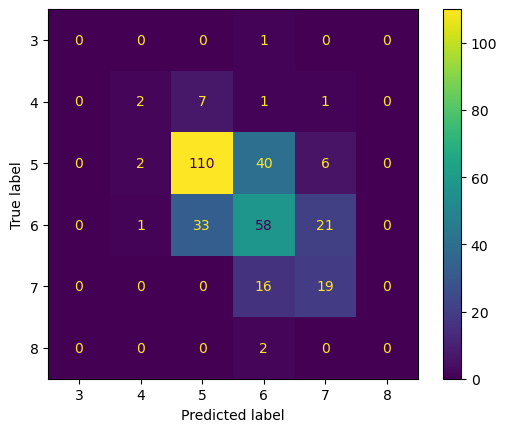

In [72]:
# Result evalution

#Find lowest mse
min_mse = min(mse_list)
min_mse_index = mse_list.index(min_mse)
min_mse_mu_prior = mu_prior_list[min_mse_index]
min_mse_sigma_prior = sigma_prior_list[min_mse_index]
min_mse_Accuracy = Accuracy_list[min_mse_index]
print("val set with lowest MSE: ")
print("MSE: ", min_mse)
print("mu_prior: ", min_mse_mu_prior)
print("sigma_prior: ", min_mse_sigma_prior)
print("Accuracy: ", min_mse_Accuracy)
print("BNN structure: ", pm_list[min_mse_index])


print("----------------------------")
# Test on test set
print("Predict on the test set")

bnn=pm_list[min_mse_index]
# bnn=pm_list[max_acc_index]

m, sd = bnn.predict(x_test_tensor.to(device), num_predictions=32)   #m is the mean of the prediction, sd is the standard deviation of the prediction

y_pred = m.cpu().detach().numpy()

mse=mse_eval(y_test, y_pred, score_display=True, result_return=True, plot_display=False)

# round the y_pred to the nearest integer, so the regression result can be compared with the classification result
y_pred = np.round(y_pred)
y_pred = np.clip(y_pred, 3, 8)
y_pred= y_pred.astype(int)
Accuracy=performance_eval(y_test, y_pred, matrix_display=True, result_return=True)



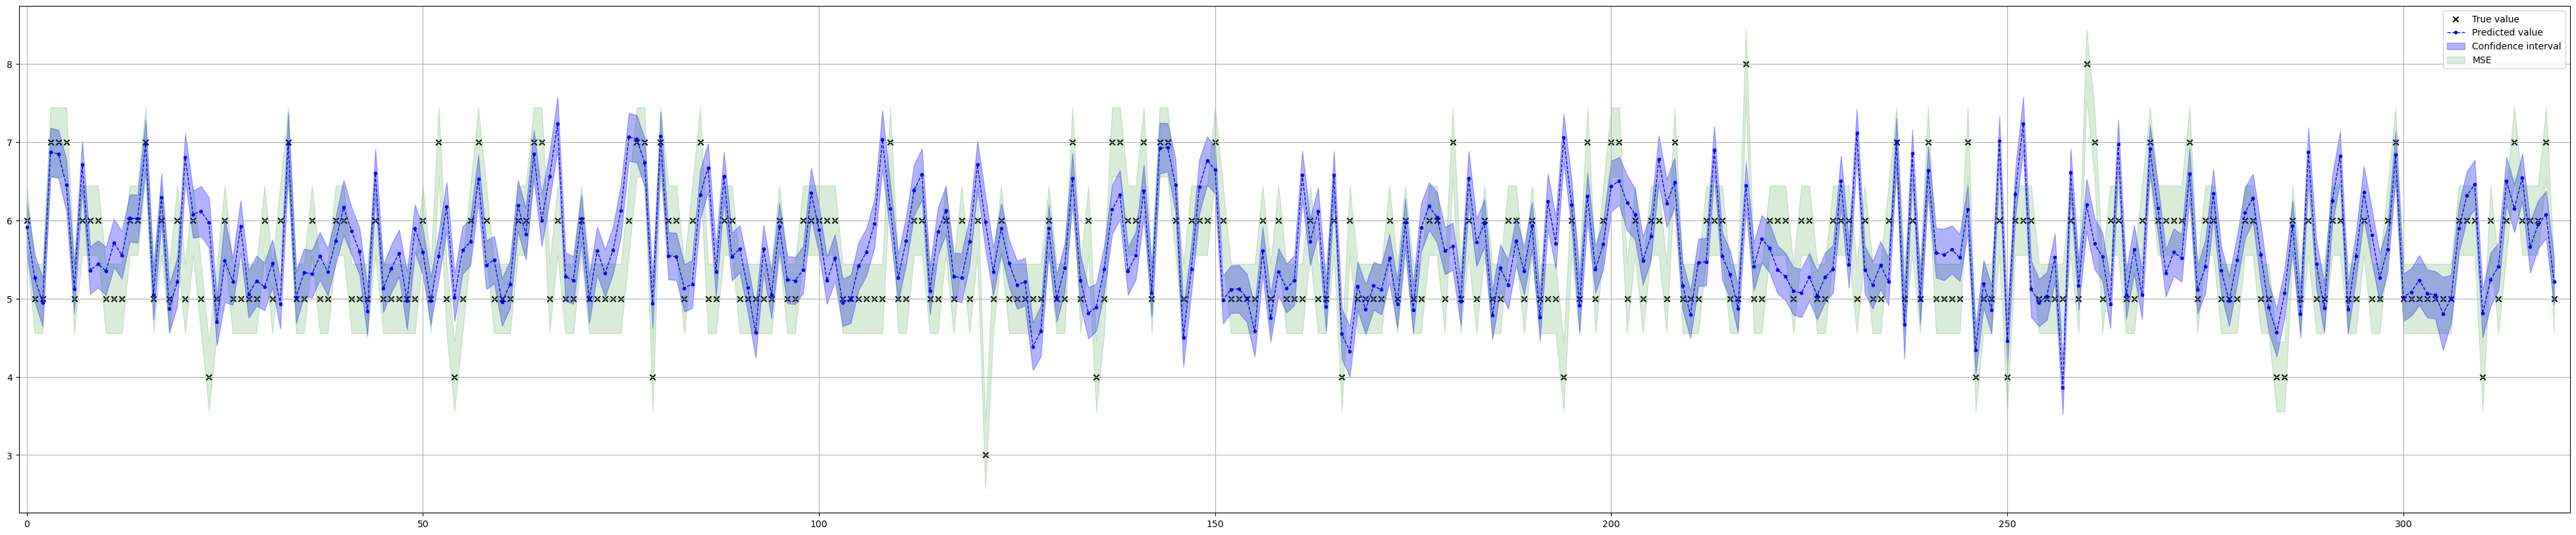

In [73]:
#Plot the prediction, true value and confidence interval
plt.figure(figsize=(50, 10))
plt.scatter(np.arange(len(y_test_tensor)), y_test_tensor.cpu(), marker="x",color="black",label='True value')
plt.plot(np.arange(len(y_test_tensor)), m.detach().cpu(), marker=".",linestyle='--',linewidth=1,color="blue",label='Predicted value')

c=3 #confidence interval, 3 standard deviation
plt.fill_between(np.arange(len(y_test_tensor)), (m - c * sd).squeeze().cpu(), (m + c * sd).squeeze().cpu(), alpha=0.3, color="b", label='Confidence interval')
plt.fill_between(np.arange(len(y_test_tensor)), y_test_tensor+mse, y_test_tensor-mse, color='green', alpha=0.15, label='MSE')
plt.xlim(-1, len(y_test_tensor)+1)
plt.legend()
plt.grid()
plt.show()
